# RQ 2: How does sentiment correlate with topic, social metrics and demographic variables?

## Resources

In [38]:
# Get Packages & Libraries
library(brms)
#library(bayesplot)
library(rethinking)
library(tidyverse)
#library(tidybayes)
library(ggplot2)
library(ggridges)
#library(viridis)
#library(stargazer)
#library(cowplot)
library(patchwork)

In [3]:
# Functions
factorize <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "character")) # that looks for variables with the character class 
      df[[i]] = as.factor(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

#unfactorize <- function(df){ # Create a function
#  for(i in which(sapply(df, class) == "factor")) # that looks for variables with the character class 
#      df[[i]] = as.character(df[[i]]) # and converts them to factor (i.e., categorical) class
#  return(df)
#}

st <- function(x){
    (x-mean(x,na.rm=TRUE))/sd(x,na.rm=TRUE)
}

In [4]:
# Get Data
# View Data
df  <- read.csv("20241011_PhD_DiaChk-RQ1b.csv")
#df[df == ''] <- NA #replace blank cells with NA
df <- factorize(df)
glimpse(df)
#colnames(df)
#sum(is.na(df))

Rows: 1,023
Columns: 51
$ docid            <fct> D0002, D0002, D0002, D0002, D0002, D0002, D0002, D000…
$ docyear          <int> 1883, 1883, 1883, 1883, 1883, 1883, 1883, 1883, 1883,…
$ docmonth         <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ authorName       <fct> Anne F. Richards, Anne F. Richards, Anne F. Richards,…
$ docauthorid      <fct> D0002, D0002, D0002, D0002, D0002, D0002, D0002, D000…
$ authorLocation   <fct> Australia, Australia, Australia, Australia, Australia…
$ authorGender     <fct> F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F,…
$ nationalOrigin   <fct> English, English, English, English, English, English,…
$ irish            <fct> False, False, False, False, False, False, False, Fals…
$ otherUK          <fct> True, True, True, True, True, True, True, True, True,…
$ relMin           <fct> False, False, False, False, False, False, False, Fals…
$ catholic         <fct> False, False, False, False, False, False, False, Fals…
$ otherChristian

## Sentiment ~ Topic

### Actual Data

In [349]:
#table(df$topicLabel, df$docauthorid)
table(df$topicNumber, df$docauthorid)

   
    D0002 D0003 D0007 D0009
  0   131     0     0     4
  1     0     0   111     0
  2     0     0   100     0
  3     5     0     0   139
  4     2   100     0     5
  5    69     0     2     0
  6    88     0     1     0
  7     0     0   109     0
  8    91     0     0     2
  9    61     2     0     1

topicLabel,min,mean,max,sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
05 Working Boy,-1.220952,0.55429737,3.690000,0.8299922
03 Business,-1.792000,0.20097870,2.753333,0.7949124
04 Girl Privilege,-2.198182,0.17991031,2.302500,0.7707285
02 Places,-2.202667,0.07328496,3.198462,0.9862676
01 Housework,-2.970000,-0.08610671,2.606667,0.9485723
09 Outback,-3.020000,-0.08919295,3.600000,0.9953434
07 People,-3.860000,-0.09771616,2.720000,1.0593159
08 Politics,-2.842500,-0.13617195,1.715000,0.8778268
10 Home,-2.510000,-0.28624665,2.373333,1.0579495


Picking joint bandwidth of 0.298



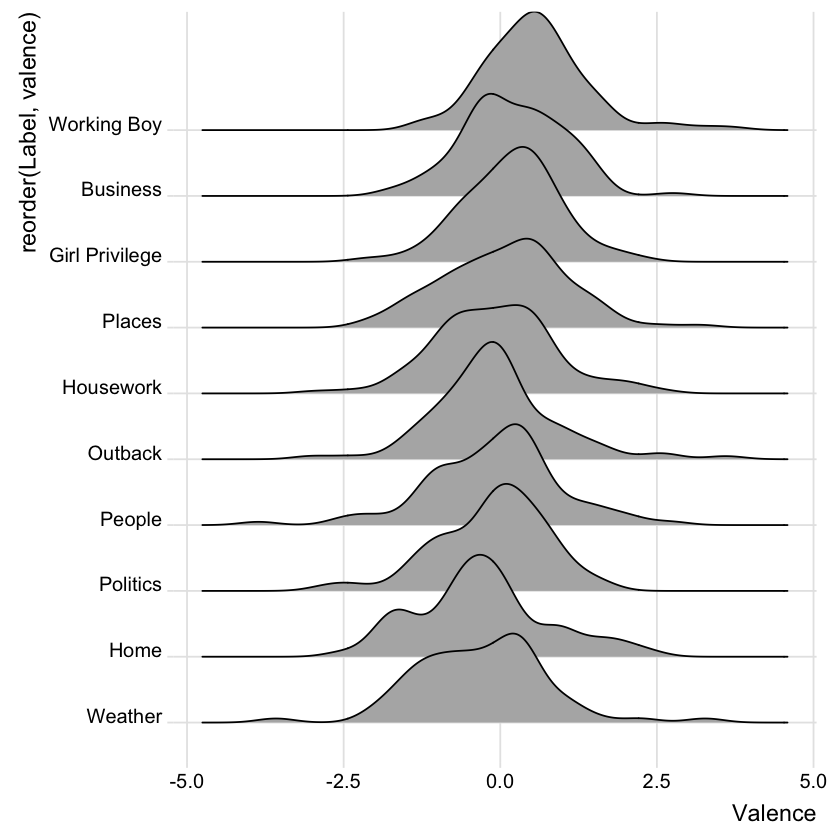

In [10]:
df %>% 
select(docauthorid, topicLabel, valence) %>% 
group_by(topicLabel) %>% 
summarize(min = min(valence),
          mean = mean(valence), 
          max = max(valence), 
          sd = sd(valence)) %>% 
arrange(desc(mean))

actualData <- df %>% 
select(docauthorid, topicLabel, valence) 

actualData$Label[actualData$topicLabel=="01 Housework"] <- "Housework"
actualData$Label[actualData$topicLabel=="02 Places"] <- "Places"
actualData$Label[actualData$topicLabel=="03 Business"] <- "Business"
actualData$Label[actualData$topicLabel=="04 Girl Privilege"] <- "Girl Privilege"
actualData$Label[actualData$topicLabel=="05 Working Boy"] <- "Working Boy"
actualData$Label[actualData$topicLabel=="06 Weather"] <- "Weather"
actualData$Label[actualData$topicLabel=="07 People"] <- "People"
actualData$Label[actualData$topicLabel=="08 Politics"] <- "Politics"
actualData$Label[actualData$topicLabel=="09 Outback"] <- "Outback"
actualData$Label[actualData$topicLabel=="10 Home"] <- "Home"

ggplot(actualData, aes(x = valence, y = reorder(Label, valence))) +
  geom_density_ridges() +
theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Valence")

### Preparation of Predictor Variables

In [5]:
vars <- c('Housework',
          'Places', 
          'Business', 
          'GirlPrivilege', 
          'WorkingBoy', 
          'Weather', 
          'People',
          'Politics',
          'Outback',
          'Home'
         )
df[vars] <- 0

df$Housework[df$topicLabel=="01 Housework"] <- 1
df$Places[df$topicLabel=="02 Places"] <- 1
df$Business[df$topicLabel=="03 Business"] <- 1
df$GirlPrivilege[df$topicLabel=="04 Girl Privilege"] <- 1
df$WorkingBoy[df$topicLabel=="05 Working Boy"] <- 1
df$Weather[df$topicLabel=="06 Weather"] <- 1
df$People[df$topicLabel=="07 People"] <- 1
df$Politics[df$topicLabel=="08 Politics"] <- 1
df$Outback[df$topicLabel=="09 Outback"] <- 1
df$Home[df$topicLabel=="10 Home"] <- 1

df %>% select(all_of(vars))  %>% colSums()
table(df$topicLabel)

Housework        Places      Business GirlPrivilege    WorkingBoy 
          135           111           100           144           107 
      Weather        People      Politics       Outback          Home 
           71            89           109            93            64


     01 Housework         02 Places       03 Business 04 Girl Privilege 
              135               111               100               144 
   05 Working Boy        06 Weather         07 People       08 Politics 
              107                71                89               109 
       09 Outback           10 Home 
               93                64 

In [42]:
topics <- c("Housework", 
                 "Places", 
                 "Business", 
                 "GirlPrivilege", 
                 "WorkingBoy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home")

df$Writer[df$docauthorid=="D0002"] <- "Housewife"
df$Writer[df$docauthorid=="D0003"] <- "Labourer"
df$Writer[df$docauthorid=="D0007"] <- "Businessman"
df$Writer[df$docauthorid=="D0009"] <- "Lady"
df$Writer <- as.factor(df$Writer)

df %>% select(all_of(topics), Writer) %>% 
group_by(Writer) %>% 
summarise(across(topics, sum)) %>% 
arrange(factor(Writer, levels = c('Housewife', 'Labourer', 'Businessman', 'Lady')))

Writer,Housework,Places,Business,GirlPrivilege,WorkingBoy,Weather,People,Politics,Outback,Home
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Housewife,131,0,0,5,2,69,88,0,91,61
Labourer,0,0,0,0,100,0,0,0,0,2
Businessman,0,111,100,0,0,2,1,109,0,0
Lady,4,0,0,139,5,0,0,0,2,1


### Model Specification

<h4>Single level (completely pooled) model</h4>

$$valence_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_0 +
\beta_1Places_i + 
\beta_2Business_i + 
\beta_3GirlPrivilege_i + 
\beta_4WorkingBoy_i + 
\beta_5Weather_i + 
\beta_6People_i + 
\beta_7Politics_i + 
\beta_8Outback_i + 
\beta_9Home_i$$

$$\beta_0,...,\beta_9 \sim \mathrm{Normal}(0,1)$$
$$\sigma \sim \mathrm{Uniform}(0,1)$$ 

https://soci620.netlify.app/slides/soci620_19_randomIntercepts.pdf

<h4>Multilevel (partial pooling) model with random intercepts</h4>

$$valence_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_{0k} +
\beta_1Places_i + 
\beta_2Business_i + 
\beta_3GirlPrivilege_i + 
\beta_4WorkingBoy_i + 
\beta_5Weather_i + 
\beta_6People_i + 
\beta_7Politics_i + 
\beta_8Outback_i + 
\beta_9Home_i$$

$$\beta_{0k} = \gamma_0 + \eta_{0k}$$ 
$$\eta_{0k} \sim \mathrm{Normal}(0,\phi_0) $$ 
$$\beta_1,...,\beta_9 \sim \mathrm{Normal}(0,1)$$
$$\sigma \sim \mathrm{Uniform}(0,1)$$ 
$$\gamma_0 \sim \mathrm{Normal}(0,1)$$
$$\phi_0 \sim \mathrm{Uniform}(0,1) $$


https://soci620.netlify.app/slides/soci620_19_randomIntercepts.pdf

<h4>Multilevel (partial pooling) model with random intercepts and slopes</h4>

$$valence_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_{0k} +
\beta_{1k}Places_i + 
\beta_{2k}Business_i + 
\beta_{3k}GirlPrivilege_i + 
\beta_{4k}WorkingBoy_i + 
\beta_{5k}Weather_i + 
\beta_{6k}People_i + 
\beta_{7k}Politics_i + 
\beta_{8k}Outback_i + 
\beta_{9k}Home_i$$

$$\beta_{0k} = \gamma_{00} + \eta_{0k}$$ 

$$\beta_{1k} = \gamma_{10} + \eta_{1k}$$
$$\beta_{2k} = \gamma_{20} + \eta_{2k}$$
$$\beta_{3k} = \gamma_{30} + \eta_{3k}$$
$$\beta_{4k} = \gamma_{40} + \eta_{4k}$$
$$\beta_{5k} = \gamma_{50} + \eta_{5k}$$
$$\beta_{6k} = \gamma_{60} + \eta_{6k}$$
$$\beta_{7k} = \gamma_{70} + \eta_{7k}$$
$$\beta_{8k} = \gamma_{80} + \eta_{8k}$$
$$\beta_{9k} = \gamma_{90} + \eta_{9k}$$

$$\left[ \begin{split}\eta_{0k} \\ \eta_{1k} \\ \eta_{2k} \\ \eta_{3k} \\ \eta_{4k} \\ \eta_{5k} \\ \eta_{6k}  \\ \eta_{7k} \\ \eta_{8k} \\ \eta_{9k}\end{split} \right] \sim \mathrm{MVNormal}\left(\left[ \begin{split}0 \\ 0\\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{split} \right], \Phi R \Phi\right)$$

$$\Phi = \begin{bmatrix}\phi_0&0&0&0&0&0&0&0&0&0 \\ 0&\phi_1&0&0&0&0&0&0&0&0 \\ 0&0&\phi_2&0&0&0&0&0&0&0 \\ 0&0&0&\phi_3&0&0&0&0&0&0 \\ 0&0&0&0&\phi_4&0&0&0&0&0 \\ 0&0&0&0&0&\phi_5&0&0&0&0 \\ 0&0&0&0&0&0&\phi_6&0&0&0 \\ 0&0&0&0&0&0&0&\phi_7&0&0 \\ 0&0&0&0&0&0&0&0&\phi_8&0 \\ 0&0&0&0&0&0&0&0&0&\phi_9 \end{bmatrix}$$

$$\sigma \sim \mathrm{Uniform}(0,1)$$ 
$$\gamma_{00},...,\gamma_{90} \sim \mathrm{Normal}(0,1)$$
$$\phi_0,...,\phi_9 \sim \mathrm{Uniform}(0,1)$$
$$R \sim \mathrm{LKJ}(2)$$

https://soci620.netlify.app/slides/soci620_20_randomSlopes.pdf,
https://soci620.netlify.app/slides/soci620_21_covariancePriors.pdf,
https://soci620.netlify.app/slides/soci620_22_twoLevelModels.pdf

In [339]:
# What priors are needed?
#get_prior(formula = valence ~ 1 + Places + Business + GirlPrivilege + WorkingBoy + Weather + People + Politics + Outback + Home, family = 'gaussian', data=df)
#get_prior(formula = valence ~ 1 + Places + Business + GirlPrivilege + WorkingBoy + Weather + People + Politics + Outback + Home + (1 | docauthorid), family = 'gaussian', data=df)
#get_prior(formula = valence ~ 1 + Places + Business + GirlPrivilege + WorkingBoy + Weather + People + Politics + Outback + Home + (1 + Places + Business + GirlPrivilege + WorkingBoy + Weather + People + Politics + Outback + Home | docauthorid), family = 'gaussian', data=df)

In [327]:
# Single Level

#f1_valTop_s <- brm(formula= valence ~ 1 + 
#                   Places + 
#                   Business + 
#                   GirlPrivilege + 
#                   WorkingBoy + 
#                   Weather + 
#                   People + 
#                   Politics + 
#                   Outback + 
#                   Home, 
#           family = 'gaussian', 
#           prior=c(set_prior("normal(0,1)",class="Intercept"), # beta_0
#                   set_prior("normal(0,1)", class = "b"), # beta_1 through beta_9
#                   set_prior("uniform(0,1)",class="sigma", ub = 1)), # uncertainty on model
#           data=df, 
#           chains=4, cores=4, iter=2000, warmup = 1000, seed = 4, 
#          file = "20240917_PhD_diaChk_valTop_s", 
#           control=list(adapt_delta=.99))
#print(f1_valTop_s)

#Multi Random Intercept

#f2_valTop_mi <- brm(
#    formula= valence ~ 1 +                    
#                   Places + 
#                   Business + 
#                   GirlPrivilege + 
#                   WorkingBoy + 
#                   Weather + 
#                   People + 
#                   Politics + 
#                   Outback + 
#                   Home + (1 | docauthorid),
#    family = 'gaussian',
#    prior=c(set_prior("normal(0,1)",class="Intercept"),
#            set_prior("normal(0,1)", class = "b"),
#            set_prior("uniform(0,1)",class="sd", ub=1),
#            set_prior("uniform(0,1)",class="sigma", ub=1)),
#    data=df,
#    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#    file = "20241018_PhD_diaChk_valTop_mi",
#    control=list(adapt_delta=.99)
#)
#print(f2_valTop_mi)

#Multi Random Intercepts & Random Slopes

#f3_valTop_mis <- brm(
#    formula= valence ~ 1 +                    
#                   Places + 
#                   Business + 
#                   GirlPrivilege + 
#                   WorkingBoy + 
#                   Weather + 
#                   People + 
#                   Politics + 
#                   Outback + 
#                   Home + (1 +                    
#                   Places + 
#                   Business + 
#                   GirlPrivilege + 
#                   WorkingBoy + 
#                   Weather + 
#                   People + 
#                   Politics + 
#                   Outback + 
#                   Home | docauthorid),
#    family = 'gaussian',
#    prior=c(set_prior("normal(0,1)",class="Intercept"), # gamma_00
#            set_prior("normal(0,1)", class = "b"), # other gammas
#            set_prior("uniform(0,1)",class="sd", ub=1), # within class
#            set_prior("uniform(0,1)",class="sigma", ub=1), # between class
#            set_prior("lkj(2)", class = "cor")),
#    data=df,
#    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#    file = "20241018_PhD_diaChk_valTop_mis",
#    control=list(adapt_delta=.99)
#)

#print(f3_valTop_mis)

In [259]:
#Single Level Model
#f1_valTop_s <- readRDS("20240917_PhD_diaChk_valTop_s.rds")
#print(f1_valTop_s)

#Multi Random Intercepts
#f2_valTop_mi <- readRDS("20241018_PhD_diaChk_valTop_mi.rds")
#print(f2_valTop_mi)

#Multi Random Intercepts & Random Slopes
f3_valTop_mis <- readRDS("20241018_PhD_diaChk_valTop_mis.rds")
print(f3_valTop_mis)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: valence ~ 1 + Places + Business + GirlPrivilege + WorkingBoy + Weather + People + Politics + Outback + Home + (1 + Places + Business + GirlPrivilege + WorkingBoy + Weather + People + Politics + Outback + Home | docauthorid) 
   Data: df (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
                              Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                     0.41      0.27     0.02     0.94 1.00
sd(Places)                        0.47      0.29     0.02     0.97 1.00
sd(Business)                      0.47      0.29     0.03     0.97 1.00
sd(GirlPrivilege)                 0.39      0.28     0.01     0.95 1.00
sd(WorkingBoy)                    0.56      0.27     0.04     0.98 1.00
sd(Weather)                       0.46      0.28     0.02

### Model Comparison

In [13]:
f1_valTop_s_i <- add_criterion(f1_valTop_s, "waic")
f2_valTop_mi_i <- add_criterion(f2_valTop_mi, "waic")
f3_valTop_mis_i <- add_criterion(f3_valTop_mis, "waic")

w <- loo_compare(f1_valTop_s_i, f2_valTop_mi_i, f3_valTop_mis_i, criterion = "waic")

print(w, simplify = F)

                elpd_diff se_diff elpd_waic se_elpd_waic p_waic  se_p_waic
f3_valTop_mis_i     0.0       0.0 -1377.5      29.1         21.2     4.4  
f2_valTop_mi_i     -1.4       3.2 -1378.9      29.3         16.8     2.8  
f1_valTop_s_i      -2.1       4.2 -1379.6      28.4         11.7     0.8  
                waic    se_waic
f3_valTop_mis_i  2755.0    58.2
f2_valTop_mi_i   2757.7    58.7
f1_valTop_s_i    2759.2    56.7


### Visualization of Results

In [261]:
# New Data

nd <- data.frame(Places=c(0,1,0,0,0,0,0,0,0,0),
           Business=c(0,0,1,0,0,0,0,0,0,0),
           GirlPrivilege=c(0,0,0,1,0,0,0,0,0,0),
           WorkingBoy=c(0,0,0,0,1,0,0,0,0,0),
           Weather=c(0,0,0,0,0,1,0,0,0,0),
           People=c(0,0,0,0,0,0,1,0,0,0),
           Politics=c(0,0,0,0,0,0,0,1,0,0),
           Outback=c(0,0,0,0,0,0,0,0,1,0),
           Home=c(0,0,0,0,0,0,0,0,0,1)
          )
#nd

,Estimate,Est.Error,Q5,Q95
,<dbl>,<dbl>,<dbl>,<dbl>
Working Boy,0.55098137,0.09027878,0.40216821,0.69629642
Business,0.19926362,0.09030392,0.04872393,0.34722078
Girl Privilege,0.17851764,0.07840339,0.04738349,0.30565078
Places,0.07253703,0.08827039,-0.07336784,0.21744736
Housework,-0.08376567,0.07854904,-0.21474216,0.04854505
Outback,-0.08687920,0.09704443,-0.24396022,0.07301052
People,-0.09857805,0.09801316,-0.25746392,0.06578702
Politics,-0.13680515,0.08997744,-0.28497558,0.01343659
Home,-0.28367403,0.11125126,-0.46370722,-0.10122257


Picking joint bandwidth of 0.0158



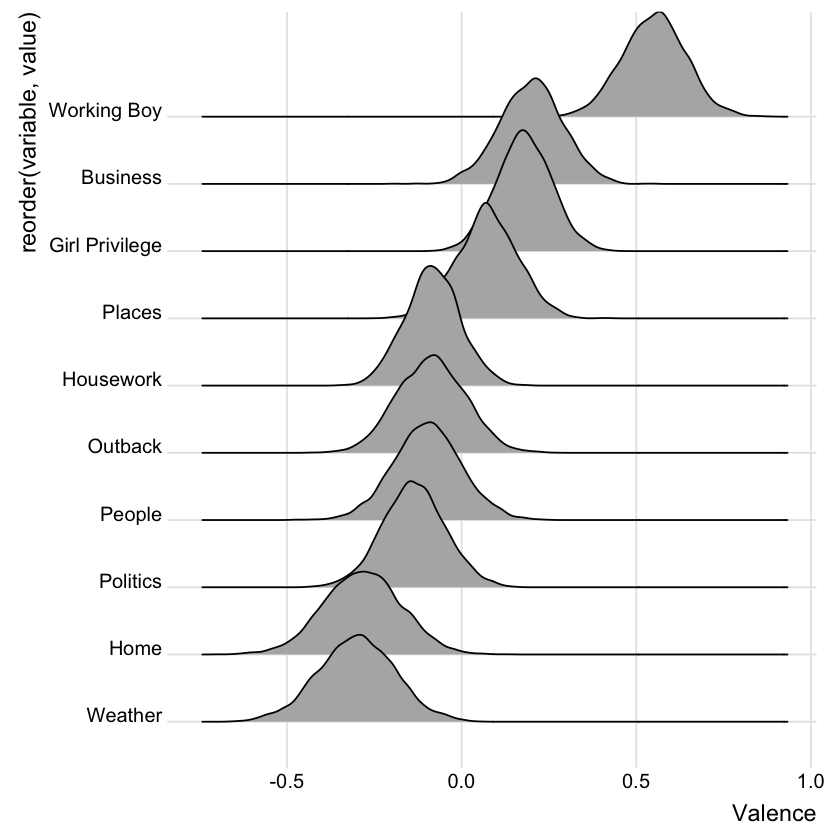

In [333]:
#Single level (completely pooled) model

f <- data.frame(fitted(f1_valTop_s,
         newdata = nd,
         probs = c(.05, .95), 
         summary = T))

rownames(f) <- c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home")

f %>% 
arrange(desc(Estimate))

f <- data.frame(fitted(f1_valTop_s,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

colnames(f) <- c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home")

f <- f %>%                                   
  gather(variable, value)

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() +
  theme(legend.position = "none") + 
xlab("Valence") 

#f <-
#  predict(f1_valTop_s,
#          newdata = nd,
#          probs = c(.05, .95),
#          summary = F) %>% 
#data.frame()

#colnames(f) <- c("Housework", # Reference case
#                 "Places", 
#                 "Business", 
#                 "Girl Privilege", 
#                 "Working Boy", 
#                 "Weather", 
#                 "People", 
#                 "Politics",
#                 "Outback",
#                 "Home")

#f <- f %>%                                   
#  gather(variable, value) 

#ggplot(f, aes(x = value, y = reorder(variable, value))) +
#  geom_density_ridges() +
#theme_ridges() + 
#  theme(legend.position = "none") + 
#xlab("Valence") 

,Estimate,Est.Error,Q5,Q95
,<dbl>,<dbl>,<dbl>,<dbl>
Business,0.52128914,0.3966066,-0.0473056,1.2221647
Places,0.39274936,0.3970923,-0.1662319,1.0924875
Politics,0.18627692,0.3993424,-0.3887414,0.8766675
Housework,0.13691643,0.3073245,-0.3287136,0.6482718
Outback,0.13474266,0.3151840,-0.3559404,0.6564687
People,0.13044447,0.3160460,-0.3509562,0.6655111
Working Boy,0.11036324,0.3767363,-0.5407070,0.6482873
Girl Privilege,0.07983150,0.3217873,-0.4599165,0.5873413
Weather,-0.07060900,0.3211111,-0.5656000,0.4725798


Picking joint bandwidth of 0.0559



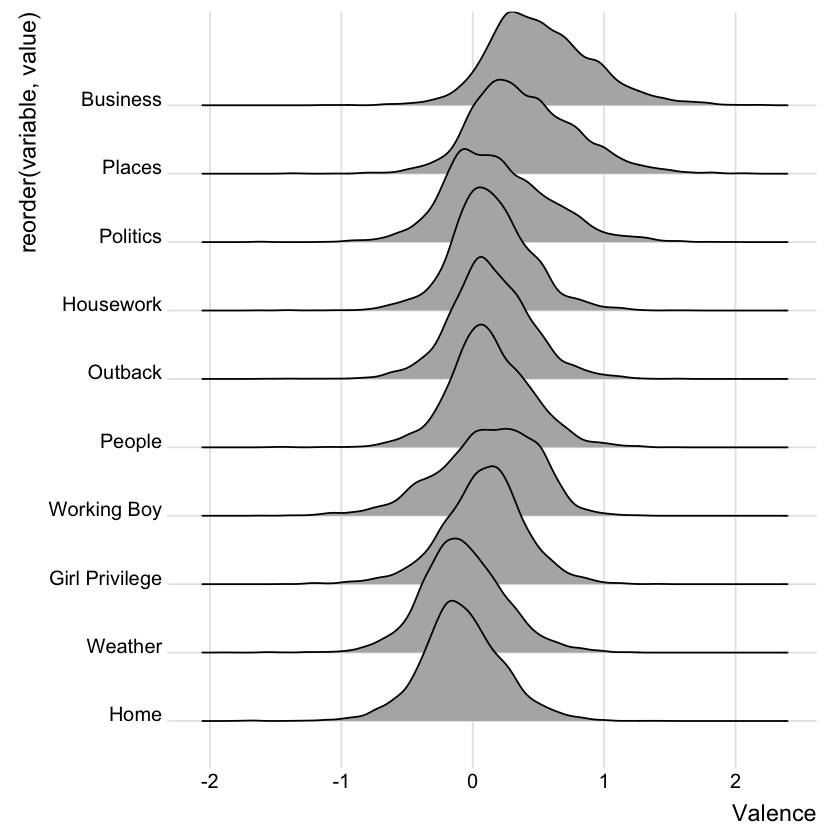

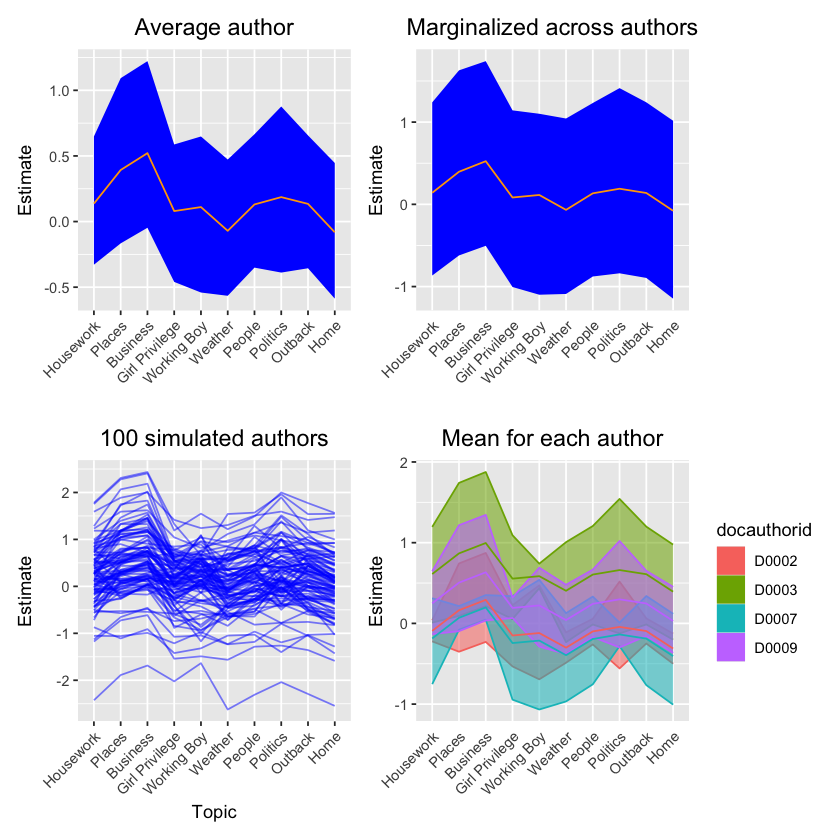

In [166]:
# Multilevel (partial pooling) model with random intercepts

# Means

f <- data.frame(fitted(f2_valTop_mi,
         newdata = nd,
         re_formula = NA,
         probs = c(.05, .95), 
         summary = T))

rownames(f) <- c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home")

f %>% 
arrange(desc(Estimate))

# Means

f <- data.frame(fitted(f2_valTop_mi, 
                       re_formula = NA,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

colnames(f) <- c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home")

f <- f %>%                                   
  gather(variable, value)

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() +
  theme(legend.position = "none") + 
xlab("Valence") 

# Predictions (including sigma)

#f <-
#  predict(f2_valTop_mi,
#          newdata = nd,
#          re_formula=NA,
#          probs = c(.05, .95),
#          summary = F) %>% 
#data.frame()

#colnames(f) <- c("Housework", # Reference case
#                 "Places", 
#                 "Business", 
#                 "Girl Privilege", 
#                 "Working Boy", 
#                 "Weather", 
#                 "People", 
#                 "Politics",
#                 "Outback",
#                 "Home")

#f <- f %>%                                   
#  gather(variable, value) 

#ggplot(f, aes(x = value, y = reorder(variable, value))) +
#  geom_density_ridges() +
#theme_ridges() + 
#  theme(legend.position = "none") + 
#xlab("Net Valence") 

f <-
  fitted(f2_valTop_mi,
         newdata = nd,
         re_formula = NA,
         probs = c(.05, .95)) %>% 
  data.frame() %>% 
  bind_cols(nd) %>% 
  mutate(topic = c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home"))  #%>% 
#arrange(Estimate)

orderTopic <- c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home")

p4 <-
  f %>%
#  ggplot(aes(x = reorder(topic, Estimate), y = Estimate, group = 1)) +
ggplot(aes(x = factor(topic, orderTopic), y = Estimate, group = 1)) +
  geom_ribbon(aes(ymin = Q5, ymax = Q95), fill = "blue") +
  geom_line(color = "orange1") +
  ggtitle("Average author") +
  theme(plot.title = element_text(size = 14, hjust = .5))+
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
 xlab("")

f <-
  fitted(f2_valTop_mi,
         newdata = nd,
         probs = c(.05, .95),
         allow_new_levels = T,
         sample_new_levels = "gaussian")

f <- f  %>% data.frame() %>% 
  bind_cols(nd)  %>% 
mutate(topic = c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home"))  #%>% 
#arrange(Estimate)

orderTopic <- c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home")

p5 <-
  f %>%
  #ggplot(aes(x = reorder(topic, Estimate), y = Estimate, group = 1)) +
  ggplot(aes(x = factor(topic, orderTopic), y = Estimate, group = 1)) +
  geom_ribbon(aes(ymin = Q5, ymax = Q95), fill = "blue") +
  geom_line(color = "orange1") +
  ggtitle("Marginalized across authors") +
  theme(plot.title = element_text(size = 14, hjust = .5))+
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
 xlab("")+ 
  theme(axis.ticks.x = element_blank())

# how many simulated chimps would you like?
n_authors <- 100

ndPlus <- nd %>%  
  # define 100 new authors
  expand_grid(author = str_c("new", 1:n_authors))  %>%
arrange(author) %>% 
  # this adds a row number, which will come in handy, later
  mutate(row = 1:n())

# fitted
set.seed(100)

f <-
  fitted(f2_valTop_mi,
         newdata = ndPlus,
         allow_new_levels = T,
         sample_new_levels = "gaussian",
         summary = F,
         ndraws = n_authors)

p6 <-
  f %>%
  data.frame() %>% 
  # name the columns by the `row` values in `nd`
  set_names(pull(ndPlus, row)) %>% 
  # add a draw index
  mutate(draw = 1:n()) %>% 
  # make it long
  pivot_longer(-draw, names_to = "row") %>% 
  mutate(row = as.double(row)) %>% 
  # add the new data
  left_join(ndPlus, by = "row") %>% 
  # extract the numbers from the names of the new actors
  mutate(author_number = str_extract(author, "\\d+") %>% as.double()) %>% 
  # only keep the posterior iterations that match the `author_number` values
  filter(author_number == draw) %>% 
  # add the `treatment` labels
  mutate(topic = rep(c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home"), 100)) %>% 
  
  # plot!
  ggplot(aes(x = factor(topic, orderTopic), y = value, group = author)) +
  geom_line(alpha = 1/2, color = "blue") +
  ggtitle("100 simulated authors") +
  theme(plot.title = element_text(size = 14, hjust = .5))+
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
 xlab("Topic")+
    ylab("Estimate")

# Means for each author

nd <- data.frame(Places=c(0,1,0,0,0,0,0,0,0,0),
           Business=c(0,0,1,0,0,0,0,0,0,0),
           GirlPrivilege=c(0,0,0,1,0,0,0,0,0,0),
           WorkingBoy=c(0,0,0,0,1,0,0,0,0,0),
           Weather=c(0,0,0,0,0,1,0,0,0,0),
           People=c(0,0,0,0,0,0,1,0,0,0),
           Politics=c(0,0,0,0,0,0,0,1,0,0),
           Outback=c(0,0,0,0,0,0,0,0,1,0),
           Home=c(0,0,0,0,0,0,0,0,0,1)
          )

housewife <- nd  %>% 
mutate(docauthorid = "D0002")

labourer <- nd  %>% 
mutate(docauthorid = "D0003")

businessman <- nd  %>% 
mutate(docauthorid = "D0007")

lady <- nd  %>% 
mutate(docauthorid = "D0009")

newdata <- rbind(housewife, labourer, businessman, lady)

f <-
  fitted(f2_valTop_mi,
         newdata = newdata,
         probs = c(.05, .95))

f <- f  %>% data.frame() %>% 
  bind_cols(newdata)%>% 
mutate(topic = rep(c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home"), 4))

#f  %>% select(Estimate, topic, docauthorid)

orderTopic <- c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home")

p7 <-
  f %>%
  #ggplot(aes(x = reorder(topic, Estimate), y = Estimate, group = 1)) +
  ggplot(aes(x = factor(topic, orderTopic), y = Estimate, group = docauthorid, color = docauthorid)) +
  geom_ribbon(aes(ymin = Q5, ymax = Q95, group = docauthorid, fill = docauthorid, alpha=.1)) +
  guides(alpha=FALSE)+
  geom_line() +
  ggtitle("Mean for each author") +
  theme(plot.title = element_text(size = 14, hjust = .5))+
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
 xlab("")+ 
  theme(axis.ticks.x = element_blank())

p4 + p5 + p6 + p7 
#p4 / p5 / p6 / plot_layout(heights=c(1,1,2))

In [268]:
fixef(f3_valTop_mis)
fixef(f3_valTop_mis)[1,1]+fixef(f3_valTop_mis)[2,1] # Places
fixef(f3_valTop_mis)[1,1]+fixef(f3_valTop_mis)[3,1] # Business
fixef(f3_valTop_mis)[1,1]+fixef(f3_valTop_mis)[4,1] # Girl Privilege
fixef(f3_valTop_mis)[1,1]+fixef(f3_valTop_mis)[5,1] # Working Boy
fixef(f3_valTop_mis)[1,1]+fixef(f3_valTop_mis)[6,1] # Weather
fixef(f3_valTop_mis)[1,1]+fixef(f3_valTop_mis)[7,1] # People
fixef(f3_valTop_mis)[1,1]+fixef(f3_valTop_mis)[8,1] # Politics
fixef(f3_valTop_mis)[1,1]+fixef(f3_valTop_mis)[9,1] # Outback
fixef(f3_valTop_mis)[1,1]+fixef(f3_valTop_mis)[10,1] # Home
#fitted(f3_valTop_mis, re_formula = NA, probs = c(.05, .95), summary = TRUE)
#fixef(f3_valTopSWB_mis)[1,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[1]] #D0002
#fixef(f3_valTopSWB_mis)[1,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[2]] #D0003
#fixef(f3_valTopSWB_mis)[1,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[3]] #D0007
#fixef(f3_valTopSWB_mis)[1,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[4]] #D0009

,Estimate,Est.Error,Q2.5,Q97.5
Intercept,0.06457684,0.2880004,-0.4566232,0.7312066
Places,0.15077073,0.5143644,-0.9227218,1.1921152
Business,0.26352828,0.5323602,-0.7759109,1.3559043
GirlPrivilege,0.01772735,0.3804550,-0.7700774,0.7402524
WorkingBoy,0.22589324,0.4480132,-0.6802965,1.0937309
Weather,-0.31130549,0.4005310,-1.2119234,0.4611354
People,-0.08765442,0.4028351,-0.9984882,0.6871829
Politics,-0.01648468,0.5137144,-1.0680650,1.0661665
Outback,0.18280865,0.4204274,-0.5910336,1.1588435
Home,0.23616017,0.4687658,-0.5956778,1.2237127


[1] 0.2153476

[1] 0.3281051

[1] 0.08230419

[1] 0.2904701

[1] -0.2467286

[1] -0.02307757

[1] 0.04809217

[1] 0.2473855

[1] 0.300737

,Estimate,Est.Error,Q5,Q95
,<dbl>,<dbl>,<dbl>,<dbl>
Business,0.32810512,0.5536262,-0.5719453,1.2732908
Home,0.30073702,0.5106409,-0.5232755,1.1678650
Working Boy,0.29047009,0.4481161,-0.4852937,0.9853178
Outback,0.24738550,0.4941246,-0.4989408,1.1172382
Places,0.21534757,0.5395075,-0.6569406,1.1025538
Girl Privilege,0.08230419,0.4080274,-0.6044685,0.7306684
Housework,0.06457684,0.2880004,-0.3664172,0.5829696
Politics,0.04809217,0.5447169,-0.8165292,0.9806606
People,-0.02307757,0.4753566,-0.8182317,0.7806535


Picking joint bandwidth of 0.0736



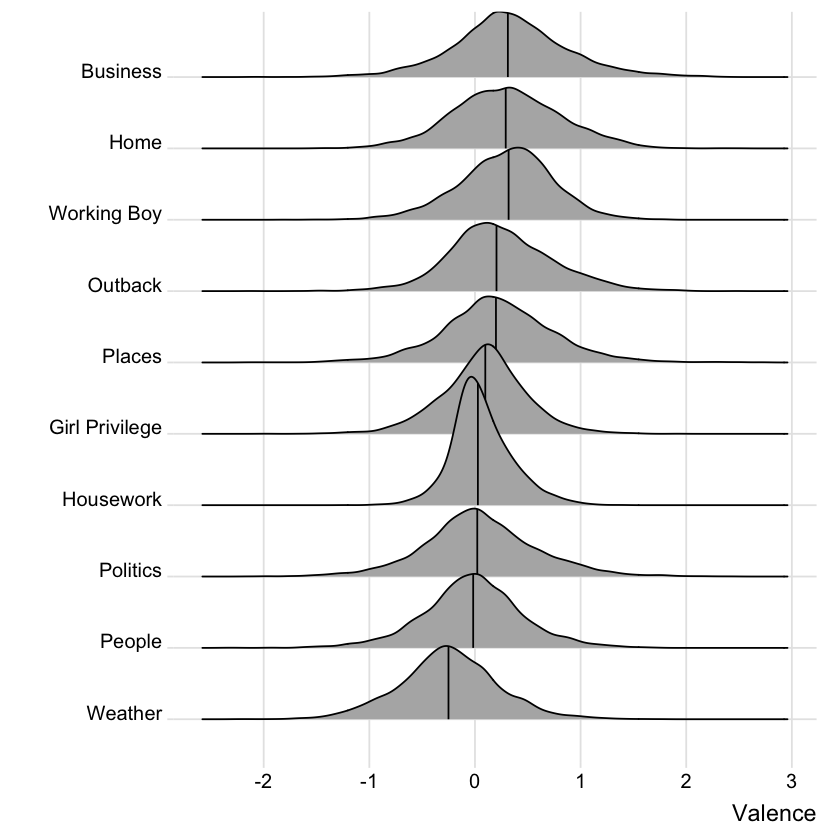

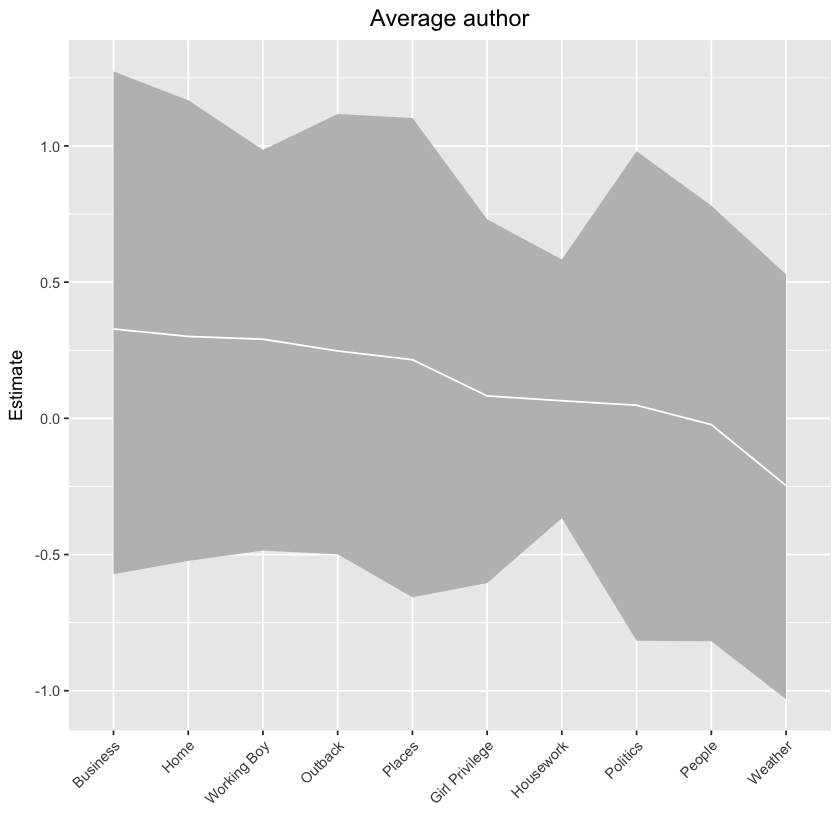

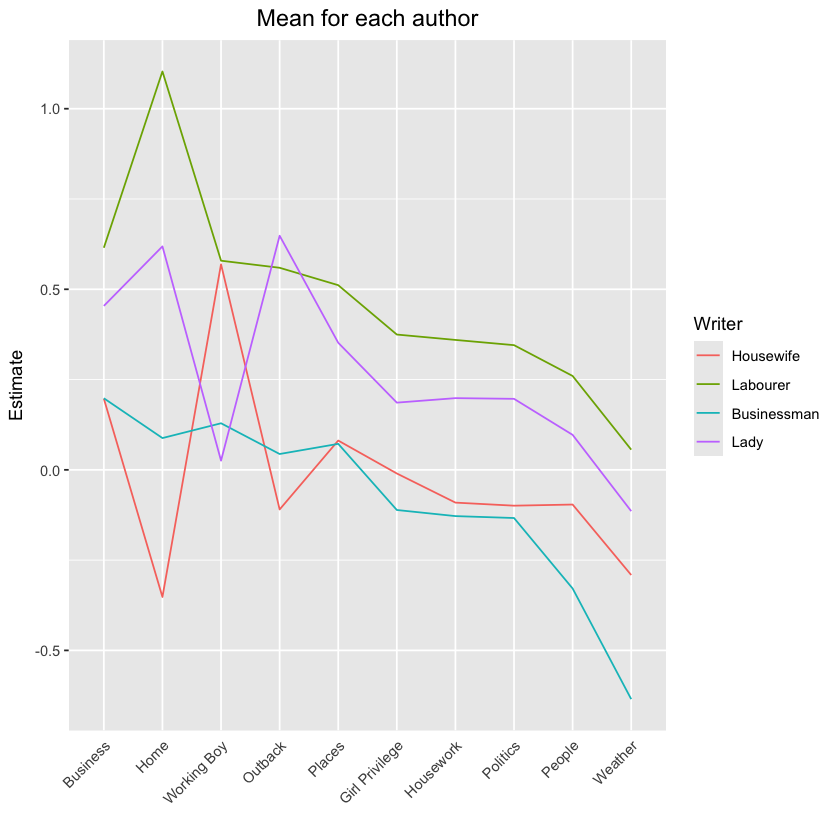

In [328]:
# New Data
nd <- data.frame(Places=c(0,1,0,0,0,0,0,0,0,0),
           Business=c(0,0,1,0,0,0,0,0,0,0),
           GirlPrivilege=c(0,0,0,1,0,0,0,0,0,0),
           WorkingBoy=c(0,0,0,0,1,0,0,0,0,0),
           Weather=c(0,0,0,0,0,1,0,0,0,0),
           People=c(0,0,0,0,0,0,1,0,0,0),
           Politics=c(0,0,0,0,0,0,0,1,0,0),
           Outback=c(0,0,0,0,0,0,0,0,1,0),
           Home=c(0,0,0,0,0,0,0,0,0,1)
          )

f <- data.frame(fitted(f3_valTop_mis,
         newdata = nd,
         re_formula = NA,
         probs = c(.05, .95), 
         summary = T))
rownames(f) <- c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home")

# Show table of means and confidence intervals
f <- f %>% 
arrange(desc(Estimate))
f

# Visualize means

f <- data.frame(fitted(f3_valTop_mis, 
                       re_formula = NA,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))


colnames(f) <- c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home")


f <- f %>%                                   
  gather(variable, value)

ggplot(f, aes(x = value, y = reorder(variable, value))) +
stat_density_ridges(quantile_lines = TRUE, quantiles = 2)+
#  geom_density_ridges() +
  theme_ridges() +
  theme(legend.position = "none") + 
xlab("Valence") +
ylab("") 

# Random effects

f <-
  fitted(f3_valTop_mis,
         newdata = nd,
         re_formula = NA,
         probs = c(.05, .95)) %>% 
  data.frame() %>% 
  bind_cols(nd) %>% 
  mutate(topic = c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home")) %>% 
arrange(desc(Estimate))

#orderTopic <- c("Housework", # Reference case
#                 "Places", 
#                 "Business", 
#                 "Girl Privilege", 
#                 "Working Boy", 
#                 "Weather", 
#                 "People", 
#                "Politics",
#                 "Outback",
#                 "Home")

p4 <-
  f %>%
ggplot(aes(x = reorder(topic, desc(Estimate)), y = Estimate, group = 1)) +
# ggplot(aes(x = factor(topic, orderTopic), y = Estimate, group = 1)) +
  geom_ribbon(aes(ymin = Q5, ymax = Q95), fill = "grey") +
  geom_line(color = "white") +
  ggtitle("Average author") +
  theme(plot.title = element_text(size = 14, hjust = .5))+
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
 xlab("")

p4

# Means for each author

nd <- data.frame(Places=c(0,1,0,0,0,0,0,0,0,0),
           Business=c(0,0,1,0,0,0,0,0,0,0),
           GirlPrivilege=c(0,0,0,1,0,0,0,0,0,0),
           WorkingBoy=c(0,0,0,0,1,0,0,0,0,0),
           Weather=c(0,0,0,0,0,1,0,0,0,0),
           People=c(0,0,0,0,0,0,1,0,0,0),
           Politics=c(0,0,0,0,0,0,0,1,0,0),
           Outback=c(0,0,0,0,0,0,0,0,1,0),
           Home=c(0,0,0,0,0,0,0,0,0,1)
          )

housewife <- nd  %>% 
mutate(docauthorid = "D0002")

labourer <- nd  %>% 
mutate(docauthorid = "D0003")

businessman <- nd  %>% 
mutate(docauthorid = "D0007")

lady <- nd  %>% 
mutate(docauthorid = "D0009")

newdata <- rbind(housewife, labourer, businessman, lady)

f <-
  fitted(f3_valTop_mis,
         newdata = newdata,
         probs = c(.05, .95))

f <- f  %>% data.frame() %>% 
  bind_cols(newdata)%>% 
mutate(topic = rep(c("Housework", # Reference case
                 "Places", 
                 "Business", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Weather", 
                 "People", 
                 "Politics",
                 "Outback",
                 "Home"), 4)) %>% 
mutate(authorLabel = c(rep("Housewife", 10), rep("Labourer", 10), rep("Businessman", 10), rep("Lady", 10)))
#f  %>% select(Estimate, topic, docauthorid)

orderTopic <- c("Business", 
                "Home", 
                "Working Boy", 
                "Outback", 
                "Places", 
                "Girl Privilege",
                "Housework",
                "Politics",
                "People",
                "Weather")
orderAuthor <- c("Housewife", 
                "Labourer", 
                "Businessman", 
                "Lady")

p7 <-
  f %>%
  #ggplot(aes(x = reorder(topic, Estimate), y = Estimate, group = 1)) +
  ggplot(aes(x = factor(topic, orderTopic), y = Estimate, group = factor(authorLabel, orderAuthor), color = factor(authorLabel, orderAuthor))) +
#  geom_ribbon(aes(ymin = Q5, ymax = Q95, group = docauthorid, color = docauthorid)) +
  geom_line() +
  ggtitle("Mean for each author") +
  theme(plot.title = element_text(size = 14, hjust = .5))+
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
 xlab("")+ 
  theme(axis.ticks.x = element_blank())+
labs(color = "Writer")

p7

## Sentiment ~ Social Metrics

<h4>Single level (completely pooled) model</h4>

$$valence_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_0 +
\beta_1socialMetric.s_i$$

$$\beta_0, \beta_1 \sim \mathrm{Normal}(0,1)$$
$$\sigma \sim \mathrm{Uniform}(0,1)$$ 

https://soci620.netlify.app/slides/soci620_19_covariancePriors.pdf (page 9)

<h4>Multilevel (partial pooling) model with random intercepts</h4>

$$valence_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_{0k} +
\beta_1socialMetric.s_i$$

$$\beta_{0k} = \gamma_0 + \eta_{0k}$$ 
$$\eta_{0k} \sim \mathrm{Normal}(0,\phi_0) $$ 
$$\beta_1 \sim \mathrm{Normal}(0,1)$$
$$\sigma \sim \mathrm{Uniform}(0,1)$$ 
$$\gamma_0 \sim \mathrm{Normal}(0,1)$$
$$\phi_0 \sim \mathrm{Uniform}(0,1) $$


https://soci620.netlify.app/slides/soci620_19_randomIntercepts.pdf (page 6)

<h4>Multilevel (partial pooling) model with random intercepts and slopes</h4>

$$valence_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_{0k} +
\beta_{1k}socialMetric.s_i $$

$$\beta_{0k} = \gamma_{00} + \eta_{0k}$$ 

$$\beta_{1k} = \gamma_{10} + \eta_{1k}$$

$$\left[ \begin{split}\eta_{0k} \\ \eta_{1k}\end{split} \right] \sim \mathrm{MVNormal}\left(\left[ \begin{split}0 \\ 0\\ \end{split} \right], \Phi R \Phi\right)$$

$$\Phi = \begin{bmatrix}\phi_0&0 \\ 0&\phi_1\end{bmatrix}$$

$$\sigma \sim \mathrm{Uniform}(0,1)$$ 
$$\gamma_{00}, \gamma_{10} \sim \mathrm{Normal}(0,1)$$
$$\phi_0,\phi_1 \sim \mathrm{Uniform}(0,1)$$
$$R \sim \mathrm{LKJ}(2)$$

https://soci620.netlify.app/slides/soci620_20_randomSlopes.pdf,
https://soci620.netlify.app/slides/soci620_21_covariancePriors.pdf,
https://soci620.netlify.app/slides/soci620_22_twoLevelModels.pdf

### External References

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.1995 -0.7165 -0.1139  0.0000  0.5835  4.4950 

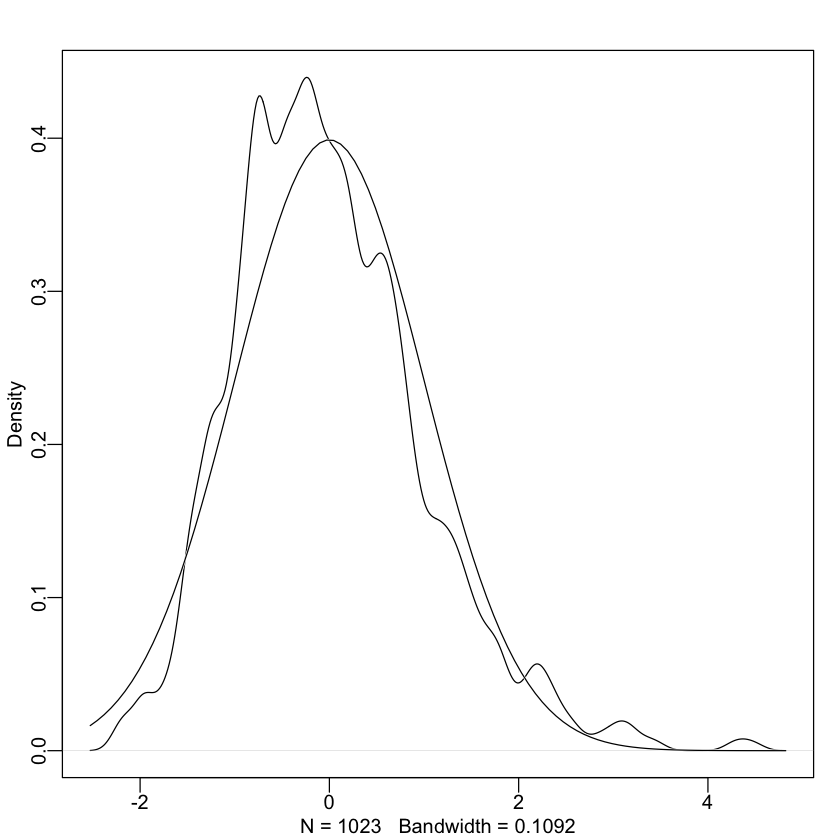

In [6]:
# Transforming variable
df$mentsRate.s <- st(df$mentsRate)
summary(df$mentsRate.s)
dens(df$mentsRate.s, norm.comp = TRUE)

In [81]:
# Single Level

#f4_valSMR_s <- brm(formula= valence ~ 1 + 
#                   mentsRate.s, 
#           family = 'gaussian', 
#           prior=c(set_prior("normal(0,1)",class="Intercept"), # beta_0
#                   set_prior("normal(0,1)", class = "b"), # beta_1 through beta_9
#                   set_prior("uniform(0,1)",class="sigma", ub = 1)), # uncertainty on model
#           data=df, 
#           chains=4, cores=4, iter=2000, warmup = 1000, seed = 4, 
#          file = "20241031_PhD_diaChk_valSMR_s", 
#           control=list(adapt_delta=.99))
#print(f4_valSMR_s)

#Multi Random Intercept

#f5_valSMR_mi <- brm(
#    formula= valence ~ 1 +                    
#                   mentsRate.s + (1 | docauthorid),
#    family = 'gaussian',
#    prior=c(set_prior("normal(0,1)",class="Intercept"),
#            set_prior("normal(0,1)", class = "b"),
#            set_prior("uniform(0,1)",class="sd", ub=1),
#            set_prior("uniform(0,1)",class="sigma", ub=1)),
#    data=df,
#    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#    file = "20241031_PhD_diaChk_valSMR_mi",
#    control=list(adapt_delta=.99)
#)
#print(f5_valSMR_mi)

#Multi Random Intercepts & Random Slopes

#f6_valSMR_mis <- brm(
#    formula= valence ~ 1 +                    
#                   mentsRate.s + (1 +                    
#                   mentsRate.s | docauthorid),
#    family = 'gaussian',
#    prior=c(set_prior("normal(0,1)",class="Intercept"), # gamma_00
#            set_prior("normal(0,1)", class = "b"), # other gammas
#            set_prior("uniform(0,1)",class="sd", ub=1), # within class
#            set_prior("uniform(0,1)",class="sigma", ub=1), # between class
#            set_prior("lkj(2)", class = "cor")),
#    data=df,
#    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#    file = "20241031_PhD_diaChk_valSMR_mis",
#    control=list(adapt_delta=.99)
#)

#print(f6_valSMR_mis)

In [157]:
#Single Level Model
#f4_valSMR_s <- readRDS("20241031_PhD_diaChk_valSMR_s.rds")
#print(f4_valSMR_s)

#Multilevel Model - Random Intercepts
f5_valSMR_mi <- readRDS("20241031_PhD_diaChk_valSMR_mi.rds")
print(f5_valSMR_mi)

#Multilevel Model - Random Intercepts & Random Slopes
f6_valSMR_mis <- readRDS("20241031_PhD_diaChk_valSMR_mis.rds")
print(f6_valSMR_mis)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: valence ~ 1 + mentsRate.s + (1 | docauthorid) 
   Data: df (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.47      0.20     0.19     0.93 1.00     1196     1376

Regression Coefficients:
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       0.16      0.25    -0.35     0.71 1.00      883     1028
mentsRate.s     0.03      0.03    -0.03     0.10 1.00     2215     1963

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.93      0.02     0.89     0.97 1.00     2437     1498

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size

### Model Comparison

In [64]:
f4_valSMR_s_i <- add_criterion(f4_valSMR_s, "waic")
f5_valSMR_mi_i <- add_criterion(f5_valSMR_mi, "waic")
f6_valSMR_mis_i <- add_criterion(f6_valSMR_mis, "waic")

w <- loo_compare(f4_valSMR_s_i, f5_valSMR_mi_i, f6_valSMR_mis_i, criterion = "waic")

print(w, simplify = F)

Automatically saving the model object in '20241031_PhD_diaChk_valSMR_s.rds'

Automatically saving the model object in '20241031_PhD_diaChk_valSMR_mi.rds'

Automatically saving the model object in '20241031_PhD_diaChk_valSMR_mis.rds'



                elpd_diff se_diff elpd_waic se_elpd_waic p_waic  se_p_waic
f6_valSMR_mis_i     0.0       0.0 -1375.7      28.8          7.6     0.6  
f5_valSMR_mi_i     -0.1       0.9 -1375.8      28.9          6.0     0.5  
f4_valSMR_s_i     -27.7       7.2 -1403.4      28.1          3.2     0.3  
                waic    se_waic
f6_valSMR_mis_i  2751.4    57.6
f5_valSMR_mi_i   2751.6    57.8
f4_valSMR_s_i    2806.8    56.2


## Visualization

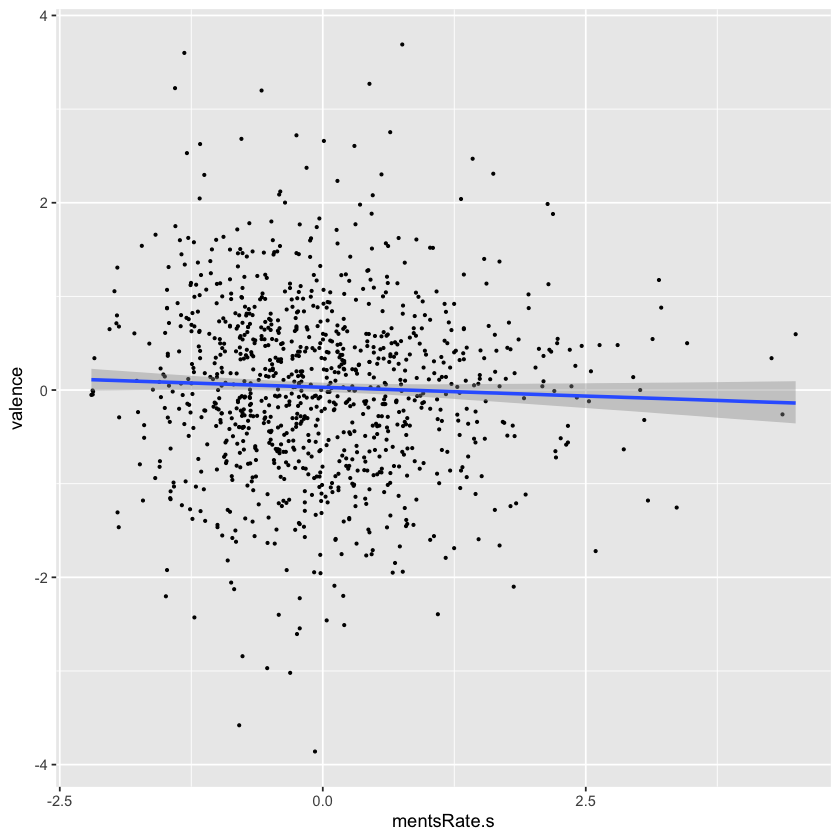

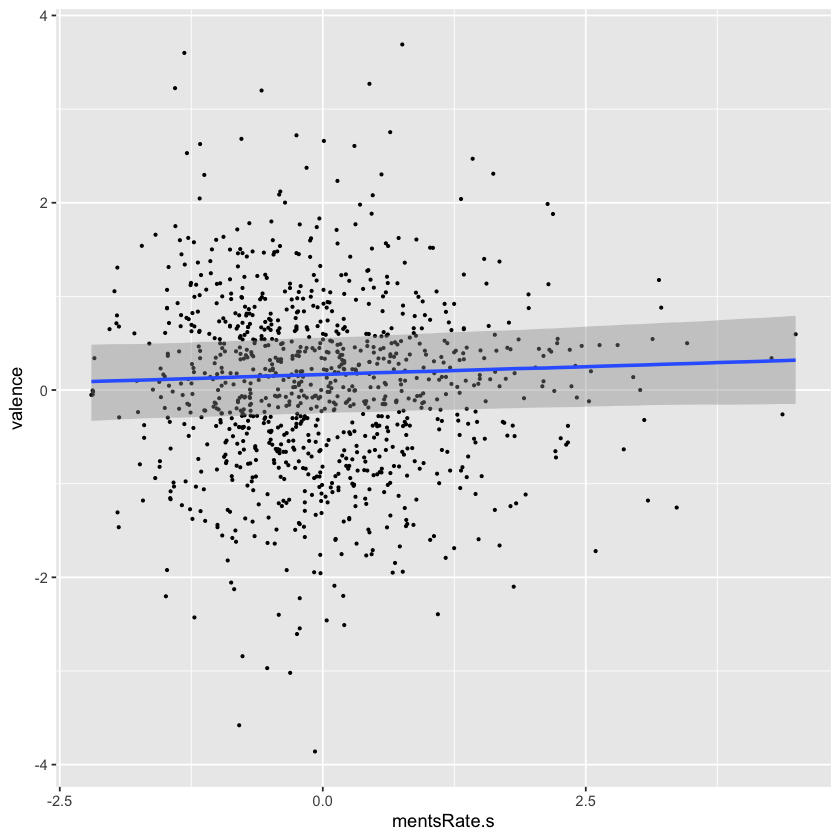

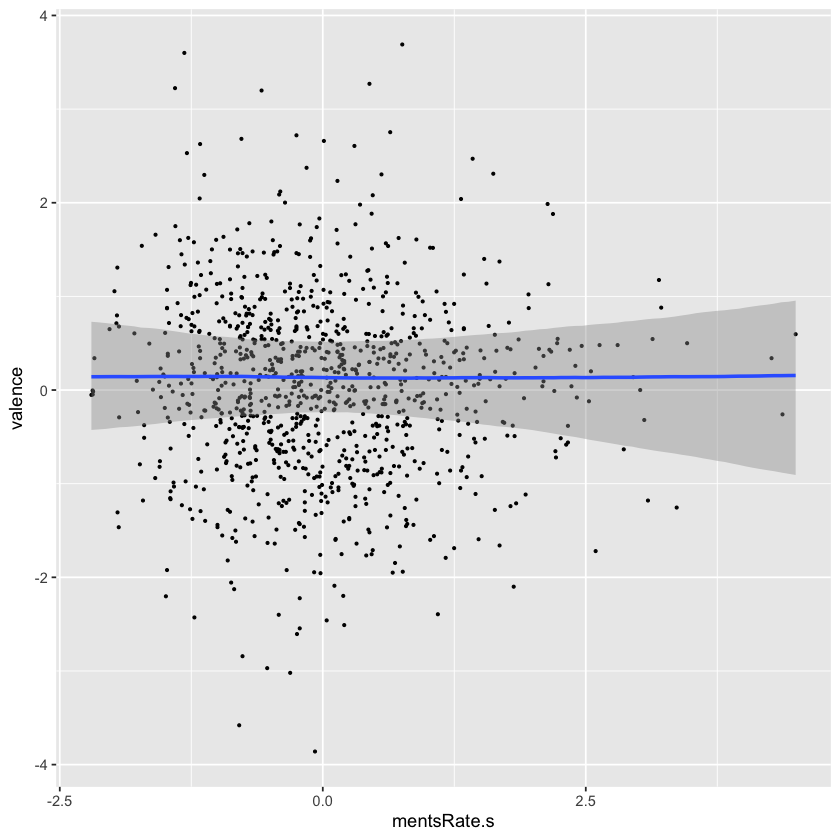

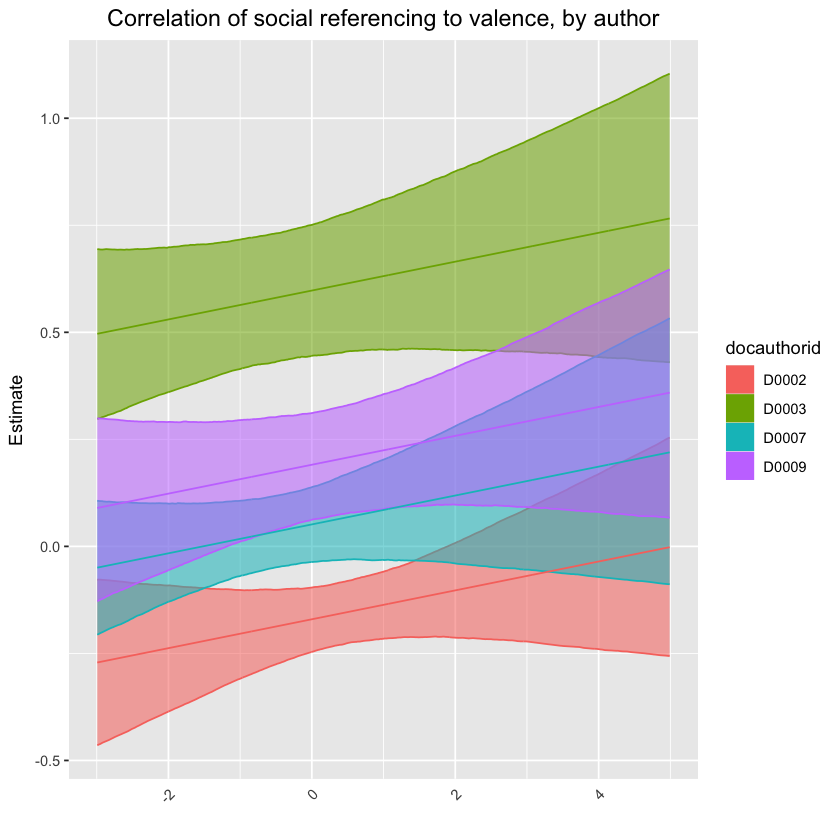

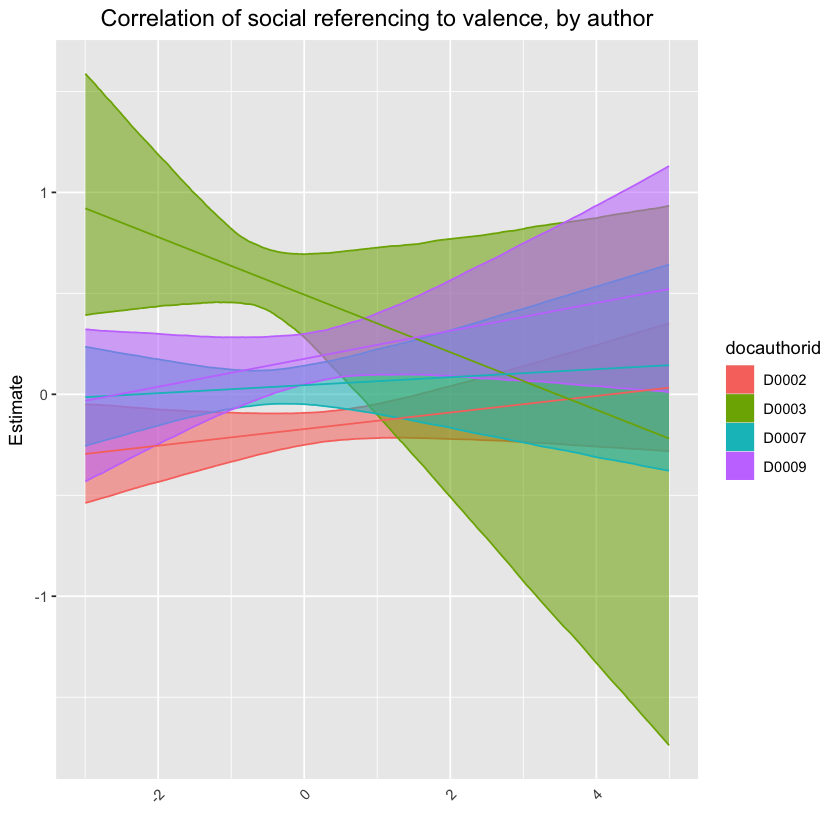

In [170]:
# Fixed Effects

plot(conditional_effects(f4_valSMR_s, prob=.90), points=T, point_args = list(size = .5))
#dev.copy(png,'20240917_PhD_DiaChkSenMenIntFix.png')
#dev.off()

plot(conditional_effects(f5_valSMR_mi, prob=.90, re_formula=NA), points=T, point_args = list(size = .5))
#dev.copy(png,'20240917_PhD_DiaChkSenMenIntFix.png')
#dev.off()

plot(conditional_effects(f6_valSMR_mis, prob=.90, re_formula=NA), points=T, point_args = list(size = .5))
#dev.copy(png,'20240917_PhD_DiaChkSenMenIntFix.png')
#dev.off()

# Random Intercepts

#nd <- data.frame(mentsRate.s=rnorm(1000, mean = 0, sd = 1))
nd <- data.frame(mentsRate.s=runif(1000, min = -3, max = 5))

housewife <- nd  %>% 
mutate(docauthorid = "D0002")

labourer <- nd  %>% 
mutate(docauthorid = "D0003")

businessman <- nd  %>% 
mutate(docauthorid = "D0007")

lady <- nd  %>% 
mutate(docauthorid = "D0009")

newdata <- rbind(housewife, labourer, businessman, lady)

f <- fitted(f5_valSMR_mi,
         newdata = newdata,
         probs = c(.05, .95))%>% 
         data.frame() %>% 
         bind_cols(newdata)
p1 <-
  f %>%
  #ggplot(aes(x = reorder(topic, Estimate), y = Estimate, group = 1)) +
  ggplot(aes(x = mentsRate.s, y = Estimate, group = docauthorid, color = docauthorid)) +
  geom_ribbon(aes(ymin = Q5, ymax = Q95, group = docauthorid, fill = docauthorid, alpha=.1)) +
  guides(alpha = FALSE)+
  geom_line() +
  ggtitle("Correlation of social referencing to valence, by author") +
  theme(plot.title = element_text(size = 14, hjust = .5))+
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
 xlab("")+ 
  theme(axis.ticks.x = element_blank())
p1

# Random Intercepts & Slopes

#nd <- data.frame(mentsRate.s=rnorm(1000, mean = 0, sd = 1))
nd <- data.frame(mentsRate.s=runif(1000, min = -3, max = 5))

housewife <- nd  %>% 
mutate(docauthorid = "D0002")

labourer <- nd  %>% 
mutate(docauthorid = "D0003")

businessman <- nd  %>% 
mutate(docauthorid = "D0007")

lady <- nd  %>% 
mutate(docauthorid = "D0009")

newdata <- rbind(housewife, labourer, businessman, lady)

f <- fitted(f6_valSMR_mis,
         newdata = newdata,
         probs = c(.05, .95))%>% 
         data.frame() %>% 
         bind_cols(newdata)
p2 <-
  f %>%
  #ggplot(aes(x = reorder(topic, Estimate), y = Estimate, group = 1)) +
  ggplot(aes(x = mentsRate.s, y = Estimate, group = docauthorid, color = docauthorid)) +
  geom_ribbon(aes(ymin = Q5, ymax = Q95, group = docauthorid, fill = docauthorid, alpha=.1)) +
  guides(alpha = FALSE)+
  geom_line() +
  ggtitle("Correlation of social referencing to valence, by author") +
  theme(plot.title = element_text(size = 14, hjust = .5))+
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
 xlab("")+ 
  theme(axis.ticks.x = element_blank())
p2

### Sentment and Self-Referencing (All First Person Pronouns)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.6502 -0.7457 -0.1593  0.0000  0.4797  4.0010 

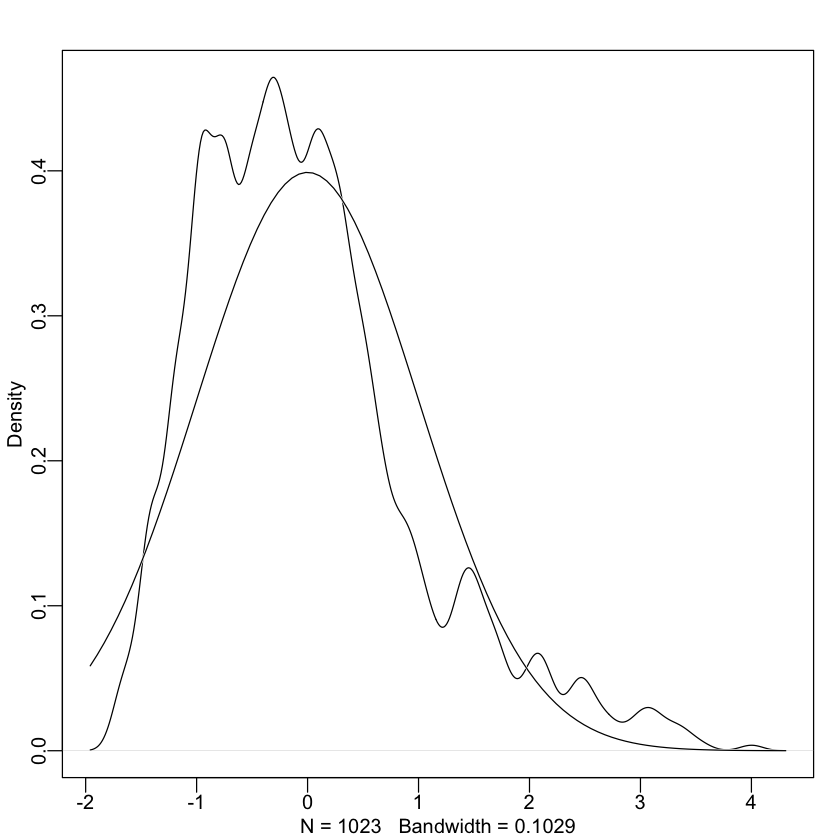

In [7]:
# Transforming variable
df$fppAllRate.s <- st(df$fppAllRate)
summary(df$fppAllRate.s)
dens(df$fppAllRate.s, norm.comp = TRUE)

In [139]:
#Multi Random Intercept

#f7_valFPA_mi <- brm(
#    formula= valence ~ 1 +                    
#                   fppAllRate.s + (1 | docauthorid),
#    family = 'gaussian',
#    prior=c(set_prior("normal(0,1)",class="Intercept"),
#            set_prior("normal(0,1)", class = "b"),
#            set_prior("uniform(0,1)",class="sd", ub=1),
#            set_prior("uniform(0,1)",class="sigma", ub=1)),
#    data=df,
#    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#    file = "20241031_PhD_diaChk_valFPA_mi",
#    control=list(adapt_delta=.99)
#)
#print(f7_valFPA_mi)

#Multi Random Intercepts & Random Slopes

#f8_valFPA_mis <- brm(
#    formula= valence ~ 1 +                    
#                   fppAllRate.s + (1 +                    
#                   fppAllRate.s | docauthorid),
#    family = 'gaussian',
#    prior=c(set_prior("normal(0,1)",class="Intercept"), # gamma_00
#            set_prior("normal(0,1)", class = "b"), # other gammas
#            set_prior("uniform(0,1)",class="sd", ub=1), # within class
#            set_prior("uniform(0,1)",class="sigma", ub=1), # between class
#            set_prior("lkj(2)", class = "cor")),
#    data=df,
#    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#    file = "20241031_PhD_diaChk_valFPA_mis",
#    control=list(adapt_delta=.99)
#)

#print(f8_valFPA_mis)

In [140]:
#Multilevel Model - Random Intercepts
f7_valFPA_mi <- readRDS("20241031_PhD_diaChk_valFPA_mi.rds")
print(f7_valFPA_mi)

#Multilevel Model - Random Intercepts & Random Slopes
f8_valFPA_mis <- readRDS("20241031_PhD_diaChk_valFPA_mis.rds")
print(f8_valFPA_mis)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: valence ~ 1 + fppAllRate.s + (1 | docauthorid) 
   Data: df (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.48      0.19     0.20     0.93 1.00     1204     1379

Regression Coefficients:
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        0.17      0.25    -0.35     0.72 1.00      870     1368
fppAllRate.s    -0.04      0.04    -0.11     0.03 1.00     3002     2712

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.93      0.02     0.89     0.96 1.00     2399     1557

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample 

In [141]:
f7_valFPA_mi_i <- add_criterion(f7_valFPA_mi, "waic")
f8_valFPA_mis_i <- add_criterion(f8_valFPA_mis, "waic")

w <- loo_compare(f7_valFPA_mi_i, f8_valFPA_mis_i, criterion = "waic")

print(w, simplify = F)

Automatically saving the model object in '20241031_PhD_diaChk_valFPA_mi.rds'

Automatically saving the model object in '20241031_PhD_diaChk_valFPA_mis.rds'



                elpd_diff se_diff elpd_waic se_elpd_waic p_waic  se_p_waic
f8_valFPA_mis_i     0.0       0.0 -1374.4      28.5          8.6     0.7  
f7_valFPA_mi_i     -1.2       2.3 -1375.6      28.8          6.2     0.5  
                waic    se_waic
f8_valFPA_mis_i  2748.9    57.1
f7_valFPA_mi_i   2751.3    57.6


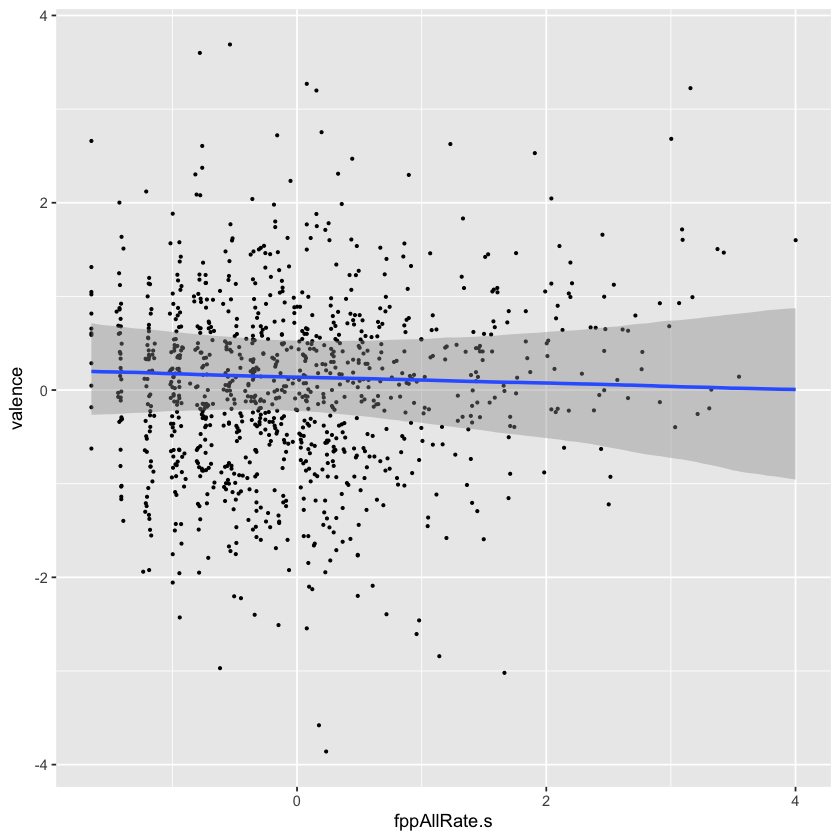

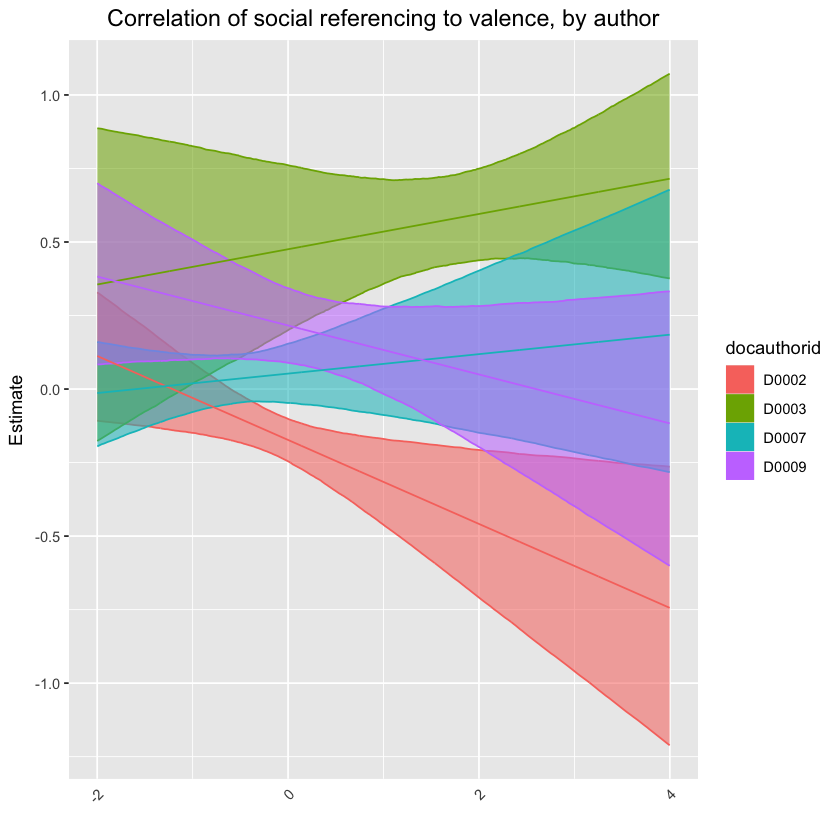

In [171]:
plot(conditional_effects(f8_valFPA_mis, prob=.90, re_formula=NA), points=T, point_args = list(size = .5))
#dev.copy(png,'20240917_PhD_DiaChkSenMenIntFix.png')
#dev.off()

# Random Slopes Model

#nd <- data.frame(fppAllRate.s=rnorm(1000, mean = 0, sd = 1))
#nd <- data.frame(fppAllRate.s=sample(df$fppAllRate.s, 1000))
nd <- data.frame(fppAllRate.s=runif(1000, min = -2, max = 4))

housewife <- nd  %>% 
mutate(docauthorid = "D0002")

labourer <- nd  %>% 
mutate(docauthorid = "D0003")

businessman <- nd  %>% 
mutate(docauthorid = "D0007")

lady <- nd  %>% 
mutate(docauthorid = "D0009")

newdata <- rbind(housewife, labourer, businessman, lady)

f <- fitted(f8_valFPA_mis,
         newdata = newdata,
         probs = c(.05, .95))%>% 
         data.frame() %>% 
         bind_cols(newdata)
p2 <-
  f %>%
  #ggplot(aes(x = reorder(topic, Estimate), y = Estimate, group = 1)) +
  ggplot(aes(x = fppAllRate.s, y = Estimate, group = docauthorid, color = docauthorid)) +
  geom_ribbon(aes(ymin = Q5, ymax = Q95, group = docauthorid, fill = docauthorid, alpha=.1)) +
  guides(alpha = FALSE)+
  geom_line() +
  ggtitle("Correlation of social referencing to valence, by author") +
  theme(plot.title = element_text(size = 14, hjust = .5))+
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
 xlab("")+ 
  theme(axis.ticks.x = element_blank())
p2

### Sentiment and Self-Referencing (Subjective First Person Pronouns)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.4532 -0.7157 -0.2286  0.0000  0.4231  3.8293 

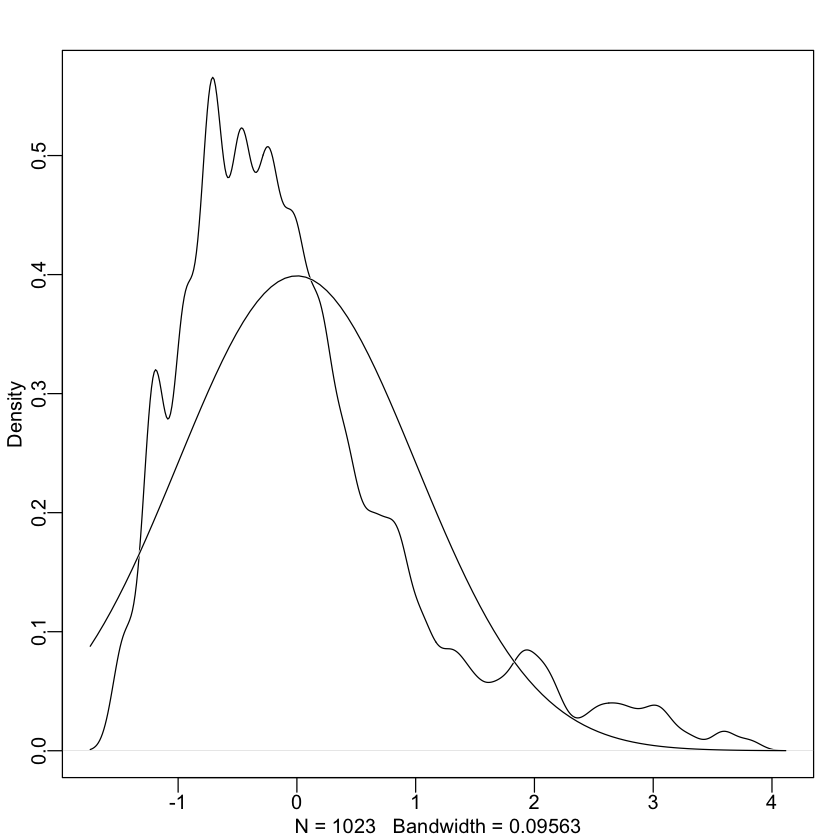

In [8]:
# Transforming variable
df$fppSubRate.s <- st(df$fppSubRate)
summary(df$fppSubRate.s)
dens(df$fppSubRate.s, norm.comp = TRUE)

In [172]:
#Multi Random Intercepts & Random Slopes

#f9_valFPS_mis <- brm(
#    formula= valence ~ 1 +                    
#                   fppSubRate.s + (1 +                    
#                   fppSubRate.s | docauthorid),
#    family = 'gaussian',
#    prior=c(set_prior("normal(0,1)",class="Intercept"), # gamma_00
#            set_prior("normal(0,1)", class = "b"), # other gammas
#            set_prior("uniform(0,1)",class="sd", ub=1), # within class
#            set_prior("uniform(0,1)",class="sigma", ub=1), # between class
#            set_prior("lkj(2)", class = "cor")),
#    data=df,
#    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#    file = "20241031_PhD_diaChk_valFPS_mis",
#    control=list(adapt_delta=.99)
#)

#print(f9_valFPS_mis)

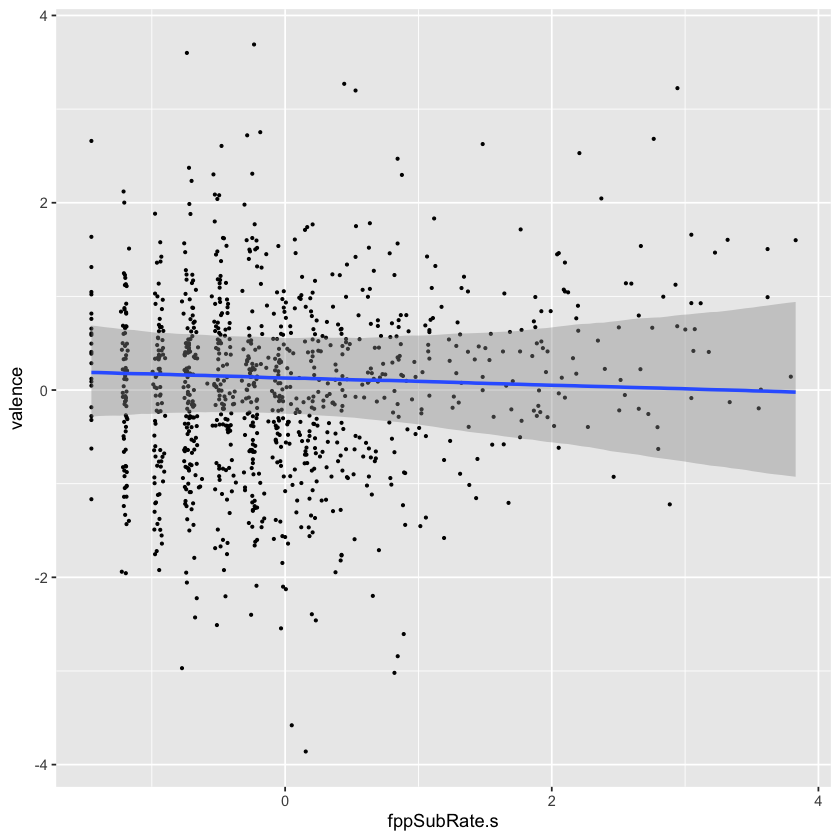

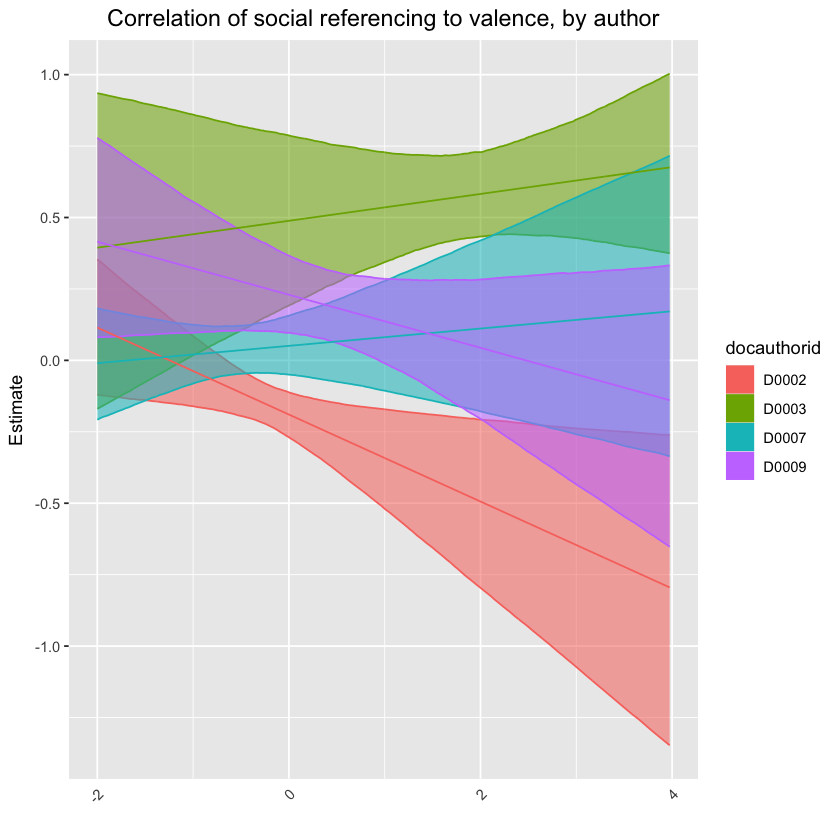

In [173]:
# Random Slopes Model

plot(conditional_effects(f9_valFPS_mis, prob=.90, re_formula=NA), points=T, point_args = list(size = .5))
#dev.copy(png,'20240917_PhD_DiaChkSenMenIntFix.png')
#dev.off()

#nd <- data.frame(fppSubRate.s=rnorm(1000, mean = 0, sd = 1))
#nd <- data.frame(fppSubRate.s=sample(df$fppSubRate.s, 1000))
nd <- data.frame(fppSubRate.s=runif(1000, min = -2, max = 4))


housewife <- nd  %>% 
mutate(docauthorid = "D0002")

labourer <- nd  %>% 
mutate(docauthorid = "D0003")

businessman <- nd  %>% 
mutate(docauthorid = "D0007")

lady <- nd  %>% 
mutate(docauthorid = "D0009")

newdata <- rbind(housewife, labourer, businessman, lady)

f <- fitted(f9_valFPS_mis,
         newdata = newdata,
         probs = c(.05, .95))%>% 
         data.frame() %>% 
         bind_cols(newdata)
p2 <-
  f %>%
  #ggplot(aes(x = reorder(topic, Estimate), y = Estimate, group = 1)) +
  ggplot(aes(x = fppSubRate.s, y = Estimate, group = docauthorid, color = docauthorid)) +
  geom_ribbon(aes(ymin = Q5, ymax = Q95, group = docauthorid, fill = docauthorid, alpha=.1)) +
  guides(alpha = FALSE)+
  geom_line() +
  ggtitle("Correlation of social referencing to valence, by author") +
  theme(plot.title = element_text(size = 14, hjust = .5))+
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
 xlab("")+ 
  theme(axis.ticks.x = element_blank())
p2

### Model Comparison (First Person Pronoun Variables)

In [151]:
f8_valFPA_mis_i <- add_criterion(f8_valFPA_mis, "waic")
f9_valFPS_mis_i <- add_criterion(f9_valFPS_mis, "waic")

w <- loo_compare(f8_valFPA_mis_i, f9_valFPS_mis_i, criterion = "waic")

print(w, simplify = F)

Automatically saving the model object in '20241031_PhD_diaChk_valFPA_mis.rds'

Automatically saving the model object in '20241031_PhD_diaChk_valFPS_mis.rds'



                elpd_diff se_diff elpd_waic se_elpd_waic p_waic  se_p_waic
f8_valFPA_mis_i     0.0       0.0 -1374.4      28.5          8.6     0.7  
f9_valFPS_mis_i    -0.2       1.3 -1374.6      28.7          8.4     0.7  
                waic    se_waic
f8_valFPA_mis_i  2748.9    57.1
f9_valFPS_mis_i  2749.2    57.4


## Revisiting Topics

In [9]:
# Importing new SWB oriented topic data
df1  <- read.csv("20241104_PhD_Topic2SWB.csv")
#glimpse(df1)

# Creating new variables
vars <- c('SE','HF','SS','RC','GI','LN','UC')
df[vars] <- NA

# Populating with new data
df['SE'][df['topicNumber']==0] <- df1['SE'][df1['Dominant_Topic']==0]
df['HF'][df['topicNumber']==0] <- df1['HF'][df1['Dominant_Topic']==0]
df['SS'][df['topicNumber']==0] <- df1['SS'][df1['Dominant_Topic']==0]
df['RC'][df['topicNumber']==0] <- df1['RC'][df1['Dominant_Topic']==0]
df['SE'][df['topicNumber']==0] <- df1['SE'][df1['Dominant_Topic']==0]
df['GI'][df['topicNumber']==0] <- df1['GI'][df1['Dominant_Topic']==0]
df['LN'][df['topicNumber']==0] <- df1['LN'][df1['Dominant_Topic']==0]
df['UC'][df['topicNumber']==0] <- df1['UC'][df1['Dominant_Topic']==0]

df['SE'][df['topicNumber']==1] <- df1['SE'][df1['Dominant_Topic']==1]
df['HF'][df['topicNumber']==1] <- df1['HF'][df1['Dominant_Topic']==1]
df['SS'][df['topicNumber']==1] <- df1['SS'][df1['Dominant_Topic']==1]
df['RC'][df['topicNumber']==1] <- df1['RC'][df1['Dominant_Topic']==1]
df['SE'][df['topicNumber']==1] <- df1['SE'][df1['Dominant_Topic']==1]
df['GI'][df['topicNumber']==1] <- df1['GI'][df1['Dominant_Topic']==1]
df['LN'][df['topicNumber']==1] <- df1['LN'][df1['Dominant_Topic']==1]
df['UC'][df['topicNumber']==1] <- df1['UC'][df1['Dominant_Topic']==1]

df['SE'][df['topicNumber']==2] <- df1['SE'][df1['Dominant_Topic']==2]
df['HF'][df['topicNumber']==2] <- df1['HF'][df1['Dominant_Topic']==2]
df['SS'][df['topicNumber']==2] <- df1['SS'][df1['Dominant_Topic']==2]
df['RC'][df['topicNumber']==2] <- df1['RC'][df1['Dominant_Topic']==2]
df['SE'][df['topicNumber']==2] <- df1['SE'][df1['Dominant_Topic']==2]
df['GI'][df['topicNumber']==2] <- df1['GI'][df1['Dominant_Topic']==2]
df['LN'][df['topicNumber']==2] <- df1['LN'][df1['Dominant_Topic']==2]
df['UC'][df['topicNumber']==2] <- df1['UC'][df1['Dominant_Topic']==2]

df['SE'][df['topicNumber']==3] <- df1['SE'][df1['Dominant_Topic']==3]
df['HF'][df['topicNumber']==3] <- df1['HF'][df1['Dominant_Topic']==3]
df['SS'][df['topicNumber']==3] <- df1['SS'][df1['Dominant_Topic']==3]
df['RC'][df['topicNumber']==3] <- df1['RC'][df1['Dominant_Topic']==3]
df['SE'][df['topicNumber']==3] <- df1['SE'][df1['Dominant_Topic']==3]
df['GI'][df['topicNumber']==3] <- df1['GI'][df1['Dominant_Topic']==3]
df['LN'][df['topicNumber']==3] <- df1['LN'][df1['Dominant_Topic']==3]
df['UC'][df['topicNumber']==3] <- df1['UC'][df1['Dominant_Topic']==3]

df['SE'][df['topicNumber']==4] <- df1['SE'][df1['Dominant_Topic']==4]
df['HF'][df['topicNumber']==4] <- df1['HF'][df1['Dominant_Topic']==4]
df['SS'][df['topicNumber']==4] <- df1['SS'][df1['Dominant_Topic']==4]
df['RC'][df['topicNumber']==4] <- df1['RC'][df1['Dominant_Topic']==4]
df['SE'][df['topicNumber']==4] <- df1['SE'][df1['Dominant_Topic']==4]
df['GI'][df['topicNumber']==4] <- df1['GI'][df1['Dominant_Topic']==4]
df['LN'][df['topicNumber']==4] <- df1['LN'][df1['Dominant_Topic']==4]
df['UC'][df['topicNumber']==4] <- df1['UC'][df1['Dominant_Topic']==4]

df['SE'][df['topicNumber']==5] <- df1['SE'][df1['Dominant_Topic']==5]
df['HF'][df['topicNumber']==5] <- df1['HF'][df1['Dominant_Topic']==5]
df['SS'][df['topicNumber']==5] <- df1['SS'][df1['Dominant_Topic']==5]
df['RC'][df['topicNumber']==5] <- df1['RC'][df1['Dominant_Topic']==5]
df['SE'][df['topicNumber']==5] <- df1['SE'][df1['Dominant_Topic']==5]
df['GI'][df['topicNumber']==5] <- df1['GI'][df1['Dominant_Topic']==5]
df['LN'][df['topicNumber']==5] <- df1['LN'][df1['Dominant_Topic']==5]
df['UC'][df['topicNumber']==5] <- df1['UC'][df1['Dominant_Topic']==5]

df['SE'][df['topicNumber']==6] <- df1['SE'][df1['Dominant_Topic']==6]
df['HF'][df['topicNumber']==6] <- df1['HF'][df1['Dominant_Topic']==6]
df['SS'][df['topicNumber']==6] <- df1['SS'][df1['Dominant_Topic']==6]
df['RC'][df['topicNumber']==6] <- df1['RC'][df1['Dominant_Topic']==6]
df['SE'][df['topicNumber']==6] <- df1['SE'][df1['Dominant_Topic']==6]
df['GI'][df['topicNumber']==6] <- df1['GI'][df1['Dominant_Topic']==6]
df['LN'][df['topicNumber']==6] <- df1['LN'][df1['Dominant_Topic']==6]
df['UC'][df['topicNumber']==6] <- df1['UC'][df1['Dominant_Topic']==6]

df['SE'][df['topicNumber']==7] <- df1['SE'][df1['Dominant_Topic']==7]
df['HF'][df['topicNumber']==7] <- df1['HF'][df1['Dominant_Topic']==7]
df['SS'][df['topicNumber']==7] <- df1['SS'][df1['Dominant_Topic']==7]
df['RC'][df['topicNumber']==7] <- df1['RC'][df1['Dominant_Topic']==7]
df['SE'][df['topicNumber']==7] <- df1['SE'][df1['Dominant_Topic']==7]
df['GI'][df['topicNumber']==7] <- df1['GI'][df1['Dominant_Topic']==7]
df['LN'][df['topicNumber']==7] <- df1['LN'][df1['Dominant_Topic']==7]
df['UC'][df['topicNumber']==7] <- df1['UC'][df1['Dominant_Topic']==7]

df['SE'][df['topicNumber']==8] <- df1['SE'][df1['Dominant_Topic']==8]
df['HF'][df['topicNumber']==8] <- df1['HF'][df1['Dominant_Topic']==8]
df['SS'][df['topicNumber']==8] <- df1['SS'][df1['Dominant_Topic']==8]
df['RC'][df['topicNumber']==8] <- df1['RC'][df1['Dominant_Topic']==8]
df['SE'][df['topicNumber']==8] <- df1['SE'][df1['Dominant_Topic']==8]
df['GI'][df['topicNumber']==8] <- df1['GI'][df1['Dominant_Topic']==8]
df['LN'][df['topicNumber']==8] <- df1['LN'][df1['Dominant_Topic']==8]
df['UC'][df['topicNumber']==8] <- df1['UC'][df1['Dominant_Topic']==8]

df['SE'][df['topicNumber']==9] <- df1['SE'][df1['Dominant_Topic']==9]
df['HF'][df['topicNumber']==9] <- df1['HF'][df1['Dominant_Topic']==9]
df['SS'][df['topicNumber']==9] <- df1['SS'][df1['Dominant_Topic']==9]
df['RC'][df['topicNumber']==9] <- df1['RC'][df1['Dominant_Topic']==9]
df['SE'][df['topicNumber']==9] <- df1['SE'][df1['Dominant_Topic']==9]
df['GI'][df['topicNumber']==9] <- df1['GI'][df1['Dominant_Topic']==9]
df['LN'][df['topicNumber']==9] <- df1['LN'][df1['Dominant_Topic']==9]
df['UC'][df['topicNumber']==9] <- df1['UC'][df1['Dominant_Topic']==9]

df %>% 
select(all_of(vars), topicLabel) %>% 
unique() %>% 
arrange(topicLabel)

df %>% 
group_by(docauthorid) %>% 
summarise_at(vars, mean)

# Standardizing Predictors
#vars <- c('SE.s','HF.s','SS.s','RC.s','GI.s', 'LN.s')
#df$SE.s <- st(df$SE)
#df$HF.s <- st(df$HF)
#df$SS.s <- st(df$SS)
#df$RC.s <- st(df$RC)
#df$GI.s <- st(df$GI)
#df$LN.s <- st(df$LN)
#df$UC.s <- st(df$UC)

SE,HF,SS,RC,GI,LN,UC,topicLabel
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.05,0.05,0.00,0.00,0.75,0.10,0.05,01 Housework
0.35,0.00,0.30,0.05,0.25,0.00,0.05,02 Places
0.55,0.00,0.25,0.00,0.15,0.00,0.05,03 Business
0.00,0.05,0.35,0.00,0.20,0.25,0.15,04 Girl Privilege
0.25,0.00,0.05,0.05,0.15,0.40,0.10,05 Working Boy
0.00,0.00,0.10,0.00,0.60,0.15,0.15,06 Weather
0.05,0.00,0.40,0.00,0.40,0.00,0.15,07 People
0.60,0.00,0.30,0.00,0.00,0.00,0.10,08 Politics
0.00,0.00,0.10,0.00,0.60,0.10,0.20,09 Outback


docauthorid,SE,HF,SS,RC,GI,LN,UC
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D0002,0.032438479,0.069798658,0.13914989,0.0002237136,0.5639821,0.0774049217,0.11700224
D0003,0.246078431,0.007843137,0.05196078,0.0490196078,0.1539216,0.3921568627,0.09901961
D0007,0.493188854,0.000000000,0.28359133,0.0171826625,0.1373065,0.0009287926,0.06780186
D0009,0.009933775,0.050000000,0.32615894,0.0016556291,0.2192053,0.2473509934,0.14569536


In [14]:
#Models

#Multi Random Intercept

#f2_valTopSWB_mi <- brm(
#    formula= valence ~ 1 +                    
#                   SE + 
#                   HF + 
#                   SS + 
#                   RC + 
#                   GI +
#                   LN +
#                   (1 | docauthorid),
#    family = 'gaussian',
#    prior=c(set_prior("normal(0,1)",class="Intercept"),
#            set_prior("normal(0,1)", class = "b"),
#            set_prior("uniform(0,1)",class="sd", ub=1),
#            set_prior("uniform(0,1)",class="sigma", ub=1)),
#    data=df,
#    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#    file = "20241104_PhD_diaChk_valTopSWB_mi",
#    control=list(adapt_delta=.99)
#)
#print(f2_valTopSWB_mi)

#Multi Random Intercepts & Random Slopes

#f3_valTopSWB_mis <- brm(
#    formula= valence ~ 1 +                    
#                   SE + 
#                   HF + 
#                   SS + 
#                   RC + 
#                   GI +
#                   LN + (1 +                    
#                   SE + 
#                   HF + 
#                   SS + 
#                   RC +
#                   GI +
#                   LN | docauthorid),
#    family = 'gaussian',
#    prior=c(set_prior("normal(0,1)",class="Intercept"), # gamma_00
#            set_prior("normal(0,1)", class = "b"), # other gammas
#            set_prior("uniform(0,1)",class="sd", ub=1), # within class
#            set_prior("uniform(0,1)",class="sigma", ub=1), # between class
#            set_prior("lkj(2)", class = "cor")),
#    data=df,
#    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#    file = "20241104_PhD_diaChk_valTopSWB_mis",
#    control=list(adapt_delta=.99)
#)

#print(f3_valTopSWB_mis)

#Multi Random Intercepts
f2_valTopSWB_mi <- readRDS("20241104_PhD_diaChk_valTopSWB_mi.rds")
#print(f2_valTopSWB_mi)

#Multi Random Intercepts & Random Slopes
f3_valTopSWB_mis <- readRDS("20241104_PhD_diaChk_valTopSWB_mis.rds")
print(f3_valTopSWB_mis)


#Model Comparison
f2_valTopSWB_mi_i <- add_criterion(f2_valTopSWB_mi, "waic")
f3_valTopSWB_mis_i <- add_criterion(f3_valTopSWB_mis, "waic")
w <- loo_compare(f2_valTopSWB_mi_i, f3_valTopSWB_mis_i, criterion = "waic")
print(w, simplify = F)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: valence ~ 1 + SE + HF + SS + RC + GI + LN + (1 + SE + HF + SS + RC + GI + LN | docauthorid) 
   Data: df (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
                  Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)         0.47      0.25     0.03     0.94 1.00     2942     2386
sd(SE)                0.49      0.29     0.02     0.98 1.00     6468     2810
sd(HF)                0.55      0.28     0.03     0.98 1.00     5309     2686
sd(SS)                0.45      0.28     0.02     0.96 1.00     6044     3238
sd(RC)                0.49      0.29     0.03     0.98 1.00     7722     2572
sd(GI)                0.54      0.27     0.03     0.98 1.00     3426     2575
sd(LN)                0.49      0.29     0.02     0.98 1.00     6060     27

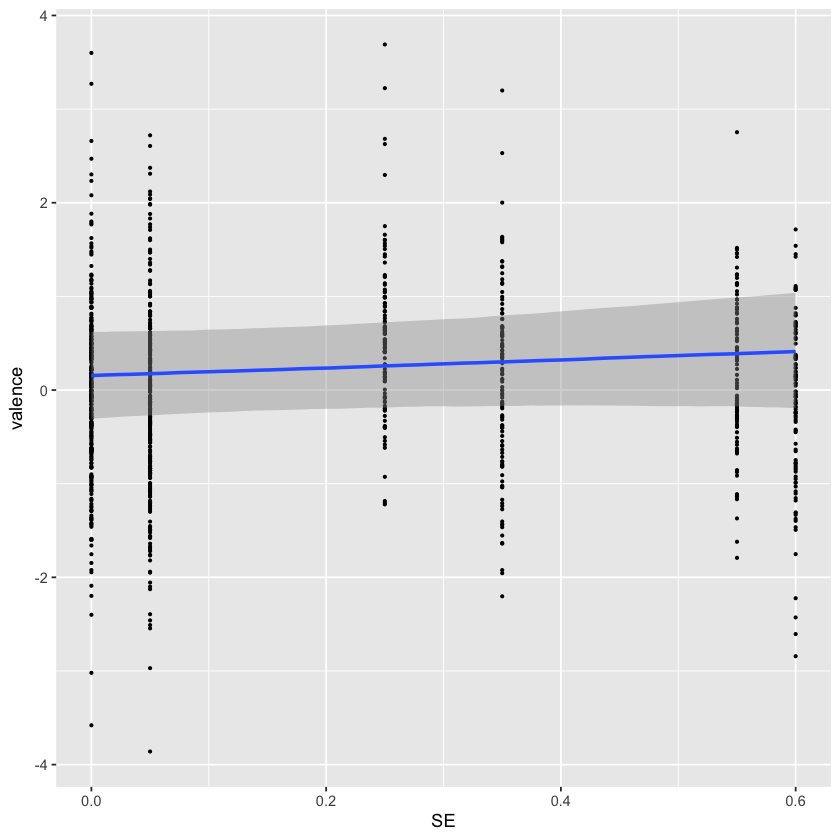

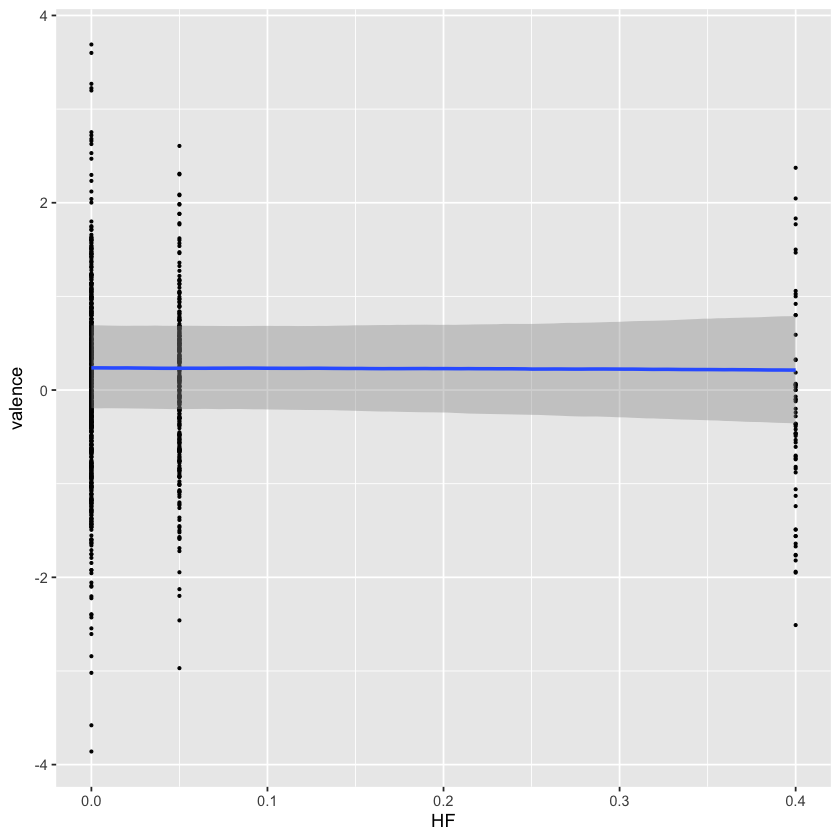

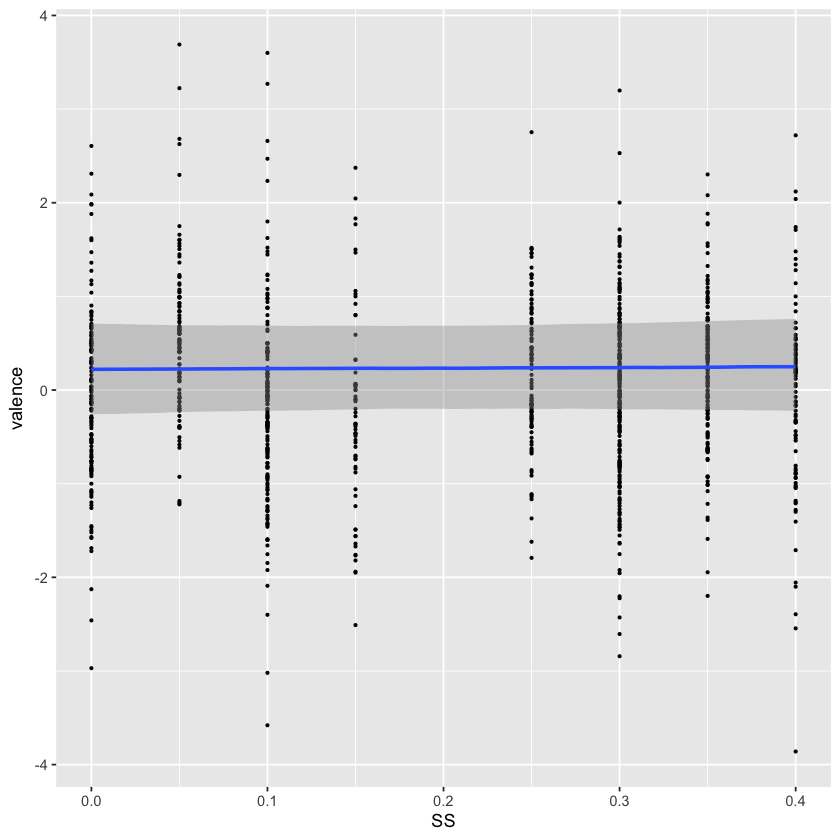

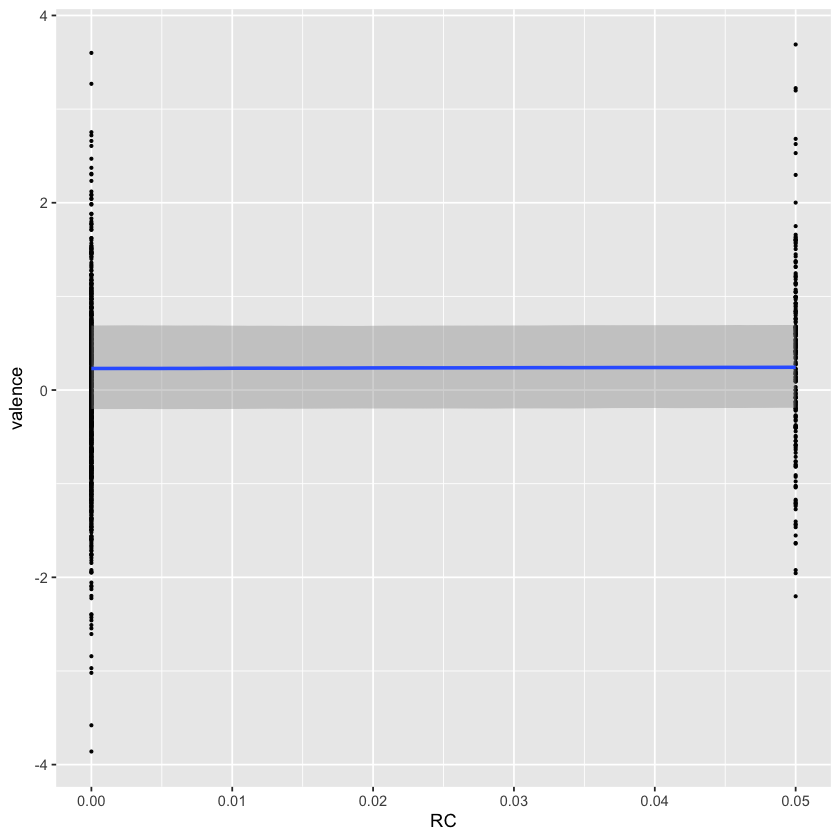

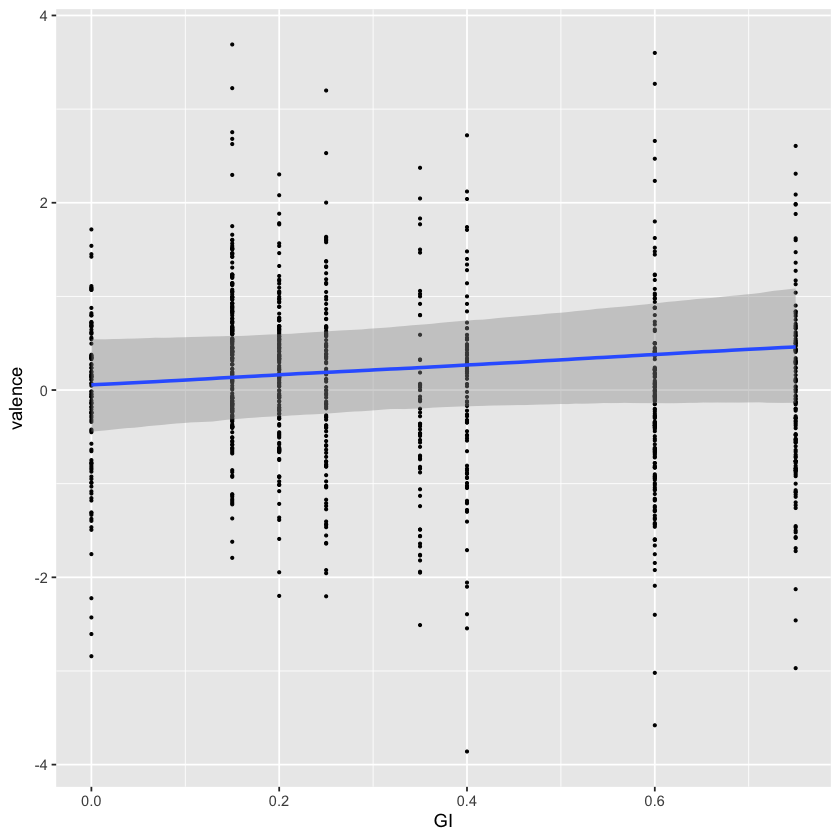

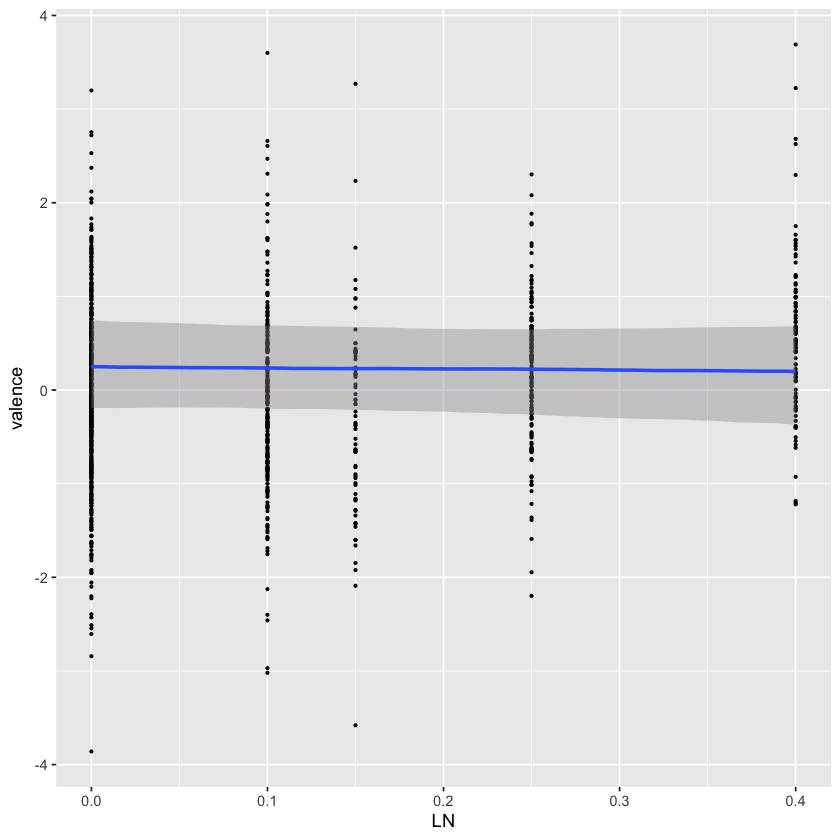

In [16]:
plot(conditional_effects(f3_valTopSWB_mis, prob=.90, re_formula=NA), points=T, point_args = list(size = .5))

Picking joint bandwidth of 0.104



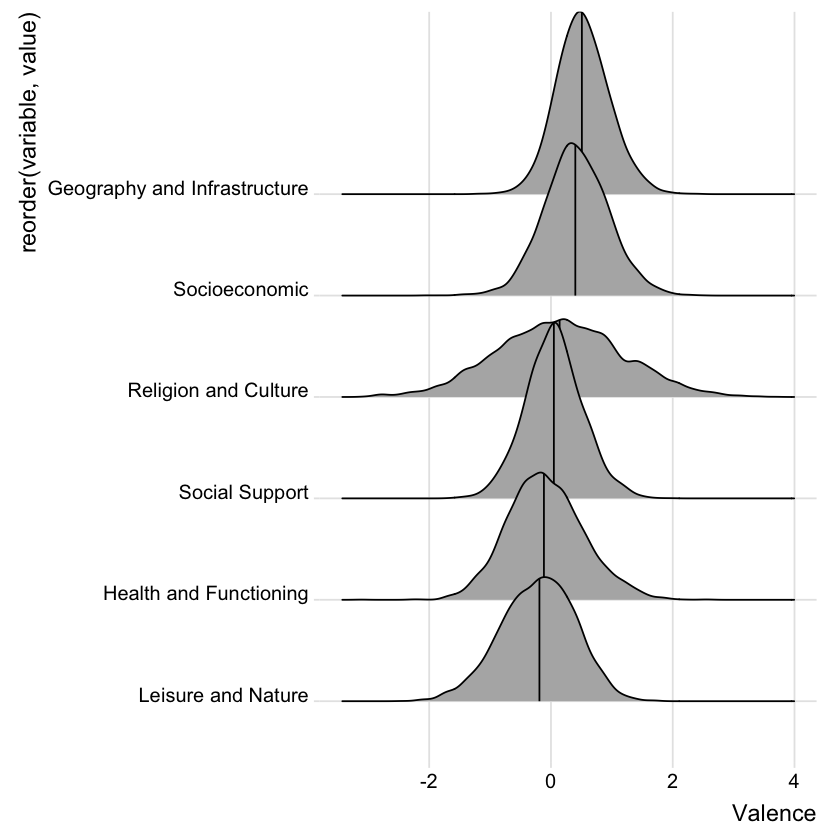

In [17]:
nd <- data.frame(SE=c(0,1,0,0,0,0,0),
                HF=c(0,0,1,0,0,0,0),
                SS=c(0,0,0,1,0,0,0),
                RC=c(0,0,0,0,1,0,0),
                GI=c(0,0,0,0,0,1,0),
                LN=c(0,0,0,0,0,0,1))

housewife <- nd  %>% 
mutate(docauthorid = "D0002") %>% 
mutate(authorLabel = "Housewife") %>% 
mutate(swbTopic = c("Unclassified",
                 "Socioeconomic", 
                 "Health and Functioning", 
                 "Social Support", 
                 "Religion and Culture", 
                 "Geography and Infrastructure", 
                 "Leisure and Nature"))

labourer <- nd  %>% 
mutate(docauthorid = "D0003")%>% 
mutate(authorLabel = "Labourer")%>% 
mutate(swbTopic = c("Unclassified",
                 "Socioeconomic", 
                 "Health and Functioning", 
                 "Social Support", 
                 "Religion and Culture", 
                 "Geography and Infrastructure", 
                 "Leisure and Nature"))

businessman <- nd  %>% 
mutate(docauthorid = "D0007") %>% 
mutate(authorLabel = "Businessman")%>% 
mutate(swbTopic = c("Unclassified",
                 "Socioeconomic", 
                 "Health and Functioning", 
                 "Social Support", 
                 "Religion and Culture", 
                 "Geography and Infrastructure", 
                 "Leisure and Nature"))

lady <- nd  %>% 
mutate(docauthorid = "D0009") %>% 
mutate(authorLabel = "Lady")%>% 
mutate(swbTopic = c("Unclassified",
                 "Socioeconomic", 
                 "Health and Functioning", 
                 "Social Support", 
                 "Religion and Culture", 
                 "Geography and Infrastructure", 
                 "Leisure and Nature"))

newdata <- rbind(housewife, labourer, businessman, lady)

# Means

f <- data.frame(fitted(f3_valTopSWB_mis, 
                       re_formula = NA,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

colnames(f) <- c("Unclassified",
                 "Socioeconomic", 
                 "Health and Functioning", 
                 "Social Support", 
                 "Religion and Culture", 
                 "Geography and Infrastructure", 
                 "Leisure and Nature")
fixed <- f[,-1]

fixed <- fixed %>%                                   
  gather(variable, value)

ggplot(fixed, aes(x = value, y = reorder(variable, value))) + # Descending order of mean valence
stat_density_ridges(quantile_lines = TRUE, quantiles = 2)+
#geom_density_ridges() +
  theme_ridges() +
  theme(legend.position = "none") + 
xlab("Valence") 

In [25]:
#fixef(f3_valTopSWB_mis)
#fixef(f3_valTopSWB_mis)[1,1]+fixef(f3_valTopSWB_mis)[2,1] # SE
#fixef(f3_valTopSWB_mis)[1,1]+fixef(f3_valTopSWB_mis)[3,1] # HF
#fixef(f3_valTopSWB_mis)[1,1]+fixef(f3_valTopSWB_mis)[4,1] # SS
#fixef(f3_valTopSWB_mis)[1,1]+fixef(f3_valTopSWB_mis)[5,1] # RC
#fixef(f3_valTopSWB_mis)[1,1]+fixef(f3_valTopSWB_mis)[6,1] # GI
#fixef(f3_valTopSWB_mis)[1,1]+fixef(f3_valTopSWB_mis)[7,1] # LN
#fitted(f3_valTopSWB_mis, re_formula = NA, newdata = nd, probs = c(.05, .95), summary = T)
fixef(f3_valTopSWB_mis)[1,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[1]] #D0002
fixef(f3_valTopSWB_mis)[1,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[2]] #D0003
fixef(f3_valTopSWB_mis)[1,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[3]] #D0007
fixef(f3_valTopSWB_mis)[1,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[4]] #D0009
#fixef(f3_valTopSWB_mis)[1,1] + fixef(f3_valTopSWB_mis)[4,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[1]] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"SS.s"][[1]]
#fixef(f3_valTopSWB_mis)[1,1] + fixef(f3_valTopSWB_mis)[4,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[2]] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"SS.s"][[2]]
#fixef(f3_valTopSWB_mis)[1,1] + fixef(f3_valTopSWB_mis)[4,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[3]] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"SS.s"][[3]]
#fixef(f3_valTopSWB_mis)[1,1] + fixef(f3_valTopSWB_mis)[4,1] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"Intercept"][[4]] + ranef(f3_valTopSWB_mis)$docauthorid[,1,"SS.s"][[4]]

[1] -0.2442234

[1] 0.3838405

[1] -0.2605366

[1] 0.06122168

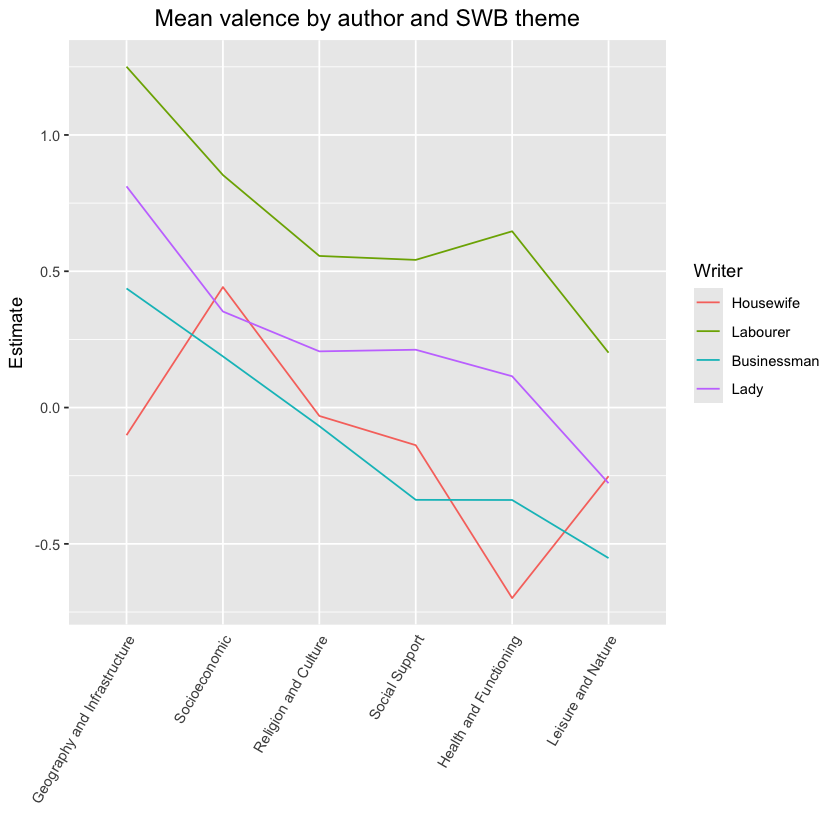

In [37]:
# Means
f <-
  fitted(f3_valTopSWB_mis,
         newdata = newdata,
         probs = c(.05, .95)) %>% 
         data.frame() %>% 
         bind_cols(newdata)

f <- f %>% filter(swbTopic!="Unclassified")

orderTopic <- c(#"Unclassified", # Author mean when no discernible topic
                "Geography and Infrastructure",
                "Socioeconomic",
                "Religion and Culture",  
                "Social Support",
                "Health and Functioning",
                "Leisure and Nature"
                )

orderAuthor <- c("Housewife", 
                "Labourer",
                "Businessman",
                "Lady")

p8  <- f %>%
  ggplot(aes(x = factor(swbTopic, orderTopic), y = Estimate, group = factor(authorLabel, orderAuthor), color = factor(authorLabel, orderAuthor))) +
#  geom_ribbon(aes(ymin = Q5, ymax = Q95, group = factor(authorLabel, orderAuthor), color = factor(authorLabel, orderAuthor), alpha=.1)) +
#  guides(alpha=FALSE)+
  geom_line() +
  ggtitle("Mean valence by author and SWB theme") +
  theme(plot.title = element_text(size = 14, hjust = .5))+
theme(axis.text.x = element_text(angle = 60, vjust = 1, hjust=1))+
 xlab("")+ 
  theme(axis.ticks.x = element_blank())+
labs(color = "Writer")
p8

In [11]:
write.csv(df, "20241108_PhD_DiaChk-RQ2a.csv", row.names=FALSE)


### Understanding the LKJ prior

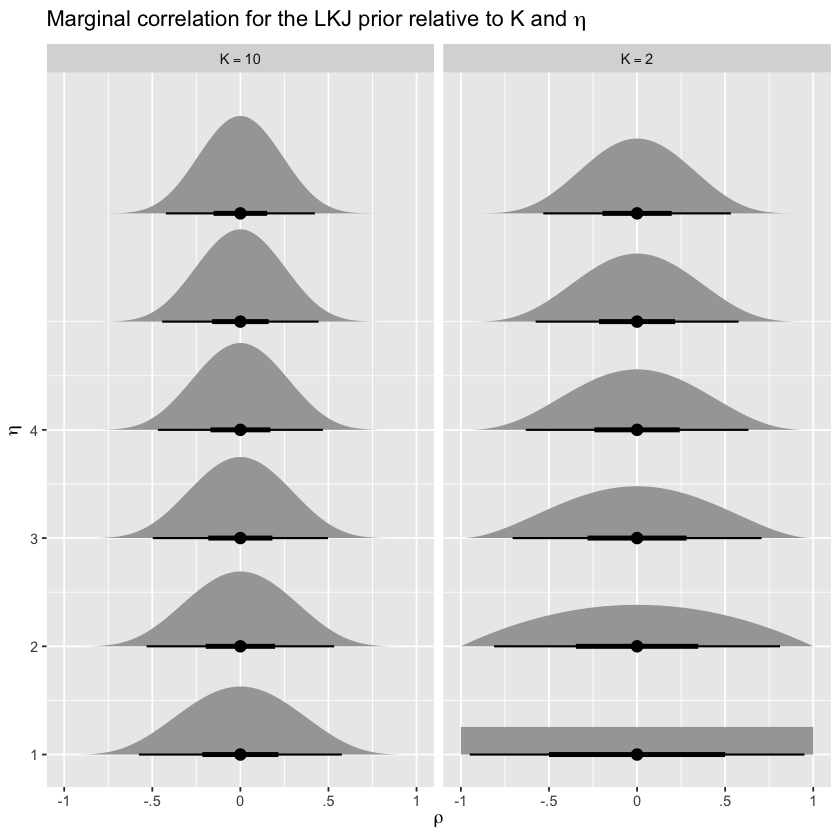

In [241]:
library(tidybayes)

crossing(k   = c(2,10),
         eta = 1:6) %>% 
  mutate(prior = str_c("lkjcorr_marginal(", k, ", ", eta, ")"),
         strip = str_c("K==", k)) %>% 
  parse_dist(prior) %>%
  
  ggplot(aes(y = eta, dist = .dist, args = .args)) +
  stat_dist_halfeye(.width = c(.5, .95)) +
  scale_x_continuous(expression(rho), limits = c(-1, 1),
                     breaks = c(-1, -.5, 0, .5, 1), labels = c("-1", "-.5", "0", ".5", "1")) +
  scale_y_continuous(expression(eta), breaks = 1:4) +
  ggtitle(expression("Marginal correlation for the LKJ prior relative to K and "*eta)) +
  facet_wrap(~strip, labeller = label_parsed, ncol = 4)

# visualize 3x3 matrix
#R <- rlkjcorr(1e3,K=10,eta=1)
#plot( R[,1,2] , R[,1,10] , col=col.alpha("black",0.2) , pch=16 )

$$\mathrm{R} = \begin{bmatrix}1&\rho_{01}&\rho_{02}&\rho_{03}&\rho_{04}&\rho_{05}&\rho_{06}&\rho_{07}&\rho_{08}&\rho_{09} \\ {\color{grey}\rho_{\color{grey}{01}}}&1&\rho_{12}&\rho_{13}&\rho_{14}&\rho_{15}&\rho_{16}&\rho_{17}&\rho_{18}&\rho_{19} \\ {\color{grey}\rho_{\color{grey}{02}}}& {\color{grey}\rho_{\color{grey}{12}}}&1&\rho_{23}&\rho_{24}&\rho_{25}&\rho_{26}&\rho_{27}&\rho_{28}&\rho_{29} \\  {\color{grey}\rho_{\color{grey}{03}}}&{\color{grey}\rho_{\color{grey}{13}}}&{\color{grey}\rho_{\color{grey}{23}}}&1&\rho_{34}&\rho_{35}&\rho_{36}&\rho_{37}&\rho_{38}&\rho_{39}  \\  {\color{grey}\rho_{\color{grey}{04}}}&{\color{grey}\rho_{\color{grey}{14}}}&{\color{grey}\rho_{\color{grey}{24}}}&{\color{grey}\rho_{\color{grey}{34}}}&1&\rho_{45}&\rho_{46}&\rho_{47}&\rho_{48}&\rho_{49}\\  {\color{grey}\rho_{\color{grey}{05}}}&{\color{grey}\rho_{\color{grey}{15}}}&{\color{grey}\rho_{\color{grey}{25}}}&{\color{grey}\rho_{\color{grey}{35}}}&{\color{grey}\rho_{\color{grey}{45}}}&1&\rho_{56}&\rho_{57}&\rho_{58}&\rho_{59} \\  {\color{grey}\rho_{\color{grey}{06}}}&{\color{grey}\rho_{\color{grey}{16}}}&{\color{grey}\rho_{\color{grey}{26}}}&{\color{grey}\rho_{\color{grey}{36}}}&{\color{grey}\rho_{\color{grey}{46}}}&{\color{grey}\rho_{\color{grey}{56}}}&1&\rho_{67}&\rho_{68}&\rho_{69} \\  {\color{grey}\rho_{\color{grey}{07}}}&{\color{grey}\rho_{\color{grey}{17}}}&{\color{grey}\rho_{\color{grey}{27}}}&{\color{grey}\rho_{\color{grey}{37}}}&{\color{grey}\rho_{\color{grey}{47}}}&{\color{grey}\rho_{\color{grey}{57}}}&{\color{grey}\rho_{\color{grey}{67}}}&1&\rho_{78}&\rho_{79} \\  {\color{grey}\rho_{\color{grey}{08}}}&{\color{grey}\rho_{\color{grey}{18}}}&{\color{grey}\rho_{\color{grey}{28}}}&{\color{grey}\rho_{\color{grey}{38}}}&{\color{grey}\rho_{\color{grey}{48}}}&{\color{grey}\rho_{\color{grey}{58}}}&{\color{grey}\rho_{\color{grey}{68}}}&{\color{grey}\rho_{\color{grey}{78}}}&1&\rho_{89} \\  {\color{grey}\rho_{\color{grey}{09}}}&{\color{grey}\rho_{\color{grey}{19}}}&{\color{grey}\rho_{\color{grey}{29}}}&{\color{grey}\rho_{\color{grey}{39}}}&{\color{grey}\rho_{\color{grey}{49}}}&{\color{grey}\rho_{\color{grey}{59}}}&{\color{grey}\rho_{\color{grey}{69}}}&{\color{grey}\rho_{\color{grey}{79}}}&{\color{grey}\rho_{\color{grey}{89}}}&1\end{bmatrix}$$